In [1]:
import netgen
import ngsolve
from ngsolve import *
import numpy as np
import math
import itertools
from more_itertools import flatten
import cmath
from numpy.linalg import matrix_power
from scipy.linalg import logm, expm
from scipy.optimize import minimize
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt

In [2]:
metrictype = 2  # 1 for analytical and 2 for background discrete metric

In [3]:
## read mesh and find the approximate metric for each element 
#  - assuming length of each side of a mesh element is unit in metric space

# read mesh file
file_name = "netgen-289-iso.vol"

# specifiy calculation norms
p_norm = 6
initialisation= 10e+3
ma = Mesh(file_name)
n_vert = ma.nv # number of vertices
n_el = ma.ne # number of elements
d = np.sqrt(3)  # length of each edge in metric space*
d = d**2


## -------for the case of implied metric------- ##

Metric_loc = np.zeros((n_el, 3))  # store the metric tensor for each element, initializes an array of no.of.elements*3

# loop over all elements
for el in ma.Elements(VOL):
    # print(type(el.nr))      # int
    # print(type(el))         # <class 'ngsolve.comp.Ngs_Element'>
    # print(el)               # <ngsolve.comp.Ngs_Element object at 0x7f8b3b3b3b70>
    
    v = el.vertices           # get the coordinates of the vertices of the element

    # get coordinates of v, in terms of x,y
    v0 = ma[v[0]].point
    v1 = ma[v[1]].point
    v2 = ma[v[2]].point

    alpha = np.array([v1[0] - v0[0], v2[0] - v1[0], v0[0] - v2[0]])
    beta = np.array([v1[1] - v0[1], v2[1] - v1[1], v0[1] - v2[1]])

    # coefficients of system of 3 linear equations
    a = np.array([alpha[0]**2, alpha[1]**2, alpha[2]**2])
    c = np.array([beta[0]**2, beta[1]**2, beta[2]**2])
    b = np.array([2*alpha[0]*beta[0], 2*alpha[1]*beta[1], 2*alpha[2]*beta[2]])

    # determinant of 3*3 linear system
    det = a[0]*(b[1]*c[2] - b[2]*c[1]) - b[0]*(a[1]*c[2] - a[2]*c[1]) + c[0]*(a[1]*b[2] - a[2]*b[1])

    # assuming length of each side of a mesh element is unit in metric space
    detx = d*(b[1]*c[2] - b[2]*c[1]) - b[0]*(d*c[2] - d*c[1]) + c[0]*(d*b[2] - d*b[1])
    dety = a[0]*(d*c[2] - d*c[1]) - d*(a[1]*c[2] - a[2]*c[1]) + c[0]*(a[1]*d - a[2]*d)
    detz = a[0]*(b[1]*d - b[2]*d) - b[0]*(a[1]*d - a[2]*d) + d*(a[1]*b[2] - a[2]*b[1])

    # value of unknowns (x , y, z) which are also 3 independent entries of the 2*2 metric tensor [x, y; y, z]
    x = detx/det
    y = dety/det
    z = detz/det
    Metric_loc[el.nr] = [x, y, z]    # el.nr gives the element number 

In [4]:
# make list of elements and thier corresponding vertex Id with rows as no. of elements and columns as no. of vertex (n_el*3)
elm_vert_list = [] 
vertices = np.zeros((n_el, 3))
x_coord = []
y_coord = []
for el in ma.Elements(VOL):
    v = el.vertices
    (a,b) = ma[v[0]].point
    x_coord.append(a)
    y_coord.append(b) 
    elm_vert_list.append(v)

#create a list of all vertices (without their coordinate values)
Entire_vert_list = []
for v in ma.vertices:
    Entire_vert_list.append(v)
print(Entire_vert_list)
Entire_vert_coordinates = []
for v in Entire_vert_list:
    Entire_vert_coordinates.append(ma[v].point)

# Example vertices and their associated netgen notation
Vertices = Entire_vert_coordinates
V = Entire_vert_list

# Create a dictionary to store the vertices and their associated metrics
Vertex_to_V = {vertex: V for vertex, V in zip(Vertices, V)}

# Function to retrieve the metric for a given vertex
def get_v(vertex):
    term = Vertex_to_V.get(vertex, None)  # Returns None if the vertex is not found
    return term

# store the metric tensor for each vertex
Implied_metric = np.zeros((n_vert, 3)) 

# store the metric and the vertex side by side
Vertices_implied_metric = []


## -------for the case of implied metric------- ##

# # for the case of implied metric, find the metric through volume averging of the surrounding metrics
# for v in ma.vertices:        # loop over all vertices
#     vol = 0
#     for el in ma[v].elements: # loop over all elements that contain the vertex v

#         v0 = ma[elm_vert_list[el.nr][0]].point  # get the coordinates of element el
#         v1 = ma[elm_vert_list[el.nr][1]].point
#         v2 = ma[elm_vert_list[el.nr][2]].point

#         # calculate volume of el
#         vol_loc = 1/6*np.abs((v1[0] - v0[0])*(v2[1] - v0[1]) - (v2[0] - v0[0])*(v1[1] - v0[1]))

#         # add metric tensor of el to the metric tensor of v
#         Implied_metric[v.nr] += vol_loc*Metric_loc[el.nr]
#         vol += vol_loc

#     # divide by the volume of the element to get the volume average of metric at node v
#     Implied_metric[v.nr] /= vol 

# # scale down the implied_metric
# Implied_metric = Implied_metric/4


## -------for the case of target metric------- ##

metric_file = open(r"adj_metric-289-iso.mtr","r")
required_file = metric_file.readlines()
required_file = required_file[1:]
for i in range(len(required_file)):
    metric = required_file[i].split()
    Implied_metric[i] = [metric[0], metric[1], metric[2]]
metric_file.close()


# store the metric and the vertex side by side - NOTE: Can do this through a class
i = 0
for v in Implied_metric:
    coordinates = ma[Entire_vert_list[i]].point
    Vertices_implied_metric.append([v,coordinates])
    i = i + 1

Implied_metric_dic = []
for metric in Implied_metric:
    matrix = np.array([[metric[0], metric[1]], [metric[1], metric[2]]])
    Implied_metric_dic.append(metric)

# Example vertices and their associated metrics
vertices = Entire_vert_coordinates
metrics = Implied_metric_dic  # Metrics corresponding to the vertices

# Create a dictionary to store the vertices and their associated metrics
vertex_to_metric = {vertex: metric for vertex, metric in zip(vertices, metrics)}

# Function to retrieve the metric for a given vertex - returns the metric in the form of a tuple (x,y,z)
def get_metric(vertex):
    term = vertex_to_metric.get(vertex, None)  # Returns None if the vertex is not found
    required = (term[0], term[1], term[2])
    return required

[V0, V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13, V14, V15, V16, V17, V18, V19, V20, V21, V22, V23, V24, V25, V26, V27, V28, V29, V30, V31, V32, V33, V34, V35, V36, V37, V38, V39, V40, V41, V42, V43, V44, V45, V46, V47, V48, V49, V50, V51, V52, V53, V54, V55, V56, V57, V58, V59, V60, V61, V62, V63, V64, V65, V66, V67, V68, V69, V70, V71, V72, V73, V74, V75, V76, V77, V78, V79, V80, V81, V82, V83, V84, V85, V86, V87, V88, V89, V90, V91, V92, V93, V94, V95, V96, V97, V98, V99, V100, V101, V102, V103, V104, V105, V106, V107, V108, V109, V110, V111, V112, V113, V114, V115, V116, V117, V118, V119, V120, V121, V122, V123, V124, V125, V126, V127, V128, V129, V130, V131, V132, V133, V134, V135, V136, V137, V138, V139, V140, V141, V142, V143, V144, V145, V146, V147, V148, V149, V150, V151, V152, V153, V154, V155, V156, V157, V158, V159, V160, V161, V162, V163, V164, V165, V166, V167, V168, V169, V170, V171, V172, V173, V174, V175, V176, V177, V178, V179, V180, V181, V182, V183, V184,

In [ ]:
##-----------------------------------------------------Some functions to be used later -----------------------------------------------------##

def find_min_min_domain(coordinates):
    min_x = min(coord[0] for coord in coordinates)
    min_y = min(coord[1] for coord in coordinates)
    return (min_x, min_y)

def find_max_max_domain(coordinates):
    max_x = max(coord[0] for coord in coordinates)
    max_y = max(coord[1] for coord in coordinates)
    return (max_x, max_y)

domain_boundary_max = find_max_max_domain(Entire_vert_coordinates)
domain_boundary_min = find_min_min_domain(Entire_vert_coordinates)

# function to return required_M = (a,b,c) when g(metric tensor, given, g = MtM)

def Required_metric(G):
    a = G[0]
    b = G[1]
    c = G[2]
    # M is an upper triangular matrix storing elements in the form [m11, m12: 0, m22]
    m11 = math.sqrt(a)
    m12 = b/m11
    m22 = math.sqrt(c - m12**2)
    M = np.array([[m11 , m12],[0, m22]])
    required_M = (M[0][0], M[0][1], M[1][1])
    return required_M


# function to find the distance between 2 points

def distance(v0,v1):
    l = ((v1[0]-v0[0])**2 + (v1[1]-v0[1])**2)**0.5
    return l


# functions for getting minimum and maximum values

def find_min_x_min_y(coordinates):
    min_x = min(coord[0][0] for coord in coordinates)
    min_y = min(coord[0][1] for coord in coordinates)
    return (min_x, min_y)
      
def find_max_x_min_y(coordinates):
    max_x = max(coord[0][0] for coord in coordinates)
    min_y = min(coord[0][1] for coord in coordinates)
    return (max_x, min_y)       

def find_min_x_max_y(coordinates):  
    min_x = min(coord[0][0] for coord in coordinates)
    max_y = max(coord[0][1] for coord in coordinates)
    return (min_x, max_y)

def find_max_x_max_y(coordinates):
    max_x = max(coord[0][0] for coord in coordinates)
    max_y = max(coord[0][1] for coord in coordinates)
    return (max_x, max_y)
 



# function to find points of the extended voronoi diagram when 3 points (2 on the boundary) and the metric field is given, for a square domain
# NOTE: cmath.sqrt will return a complex number, so use .real to get the real part of the number.
# NOTE: condition where the circumcentre will lie on the boundary edge is no t considered.

def extended_point(v1,v2,v3,C,a,b,c): # let v1,v2,v3 be the vertices of the element with boundary edge v1,v2 and (C1,C2) being the circumcentre of the triangle

    v1x,v1y = v1[0],v1[1]
    v2x,v2y = v2[0],v2[1]
    c1,c2 = C[0],C[1]

    ## for the case of a square domain
    # if v1,v2 is on the vertical boundary, then y = C2
    if v2x - v1x == 0.0:
        a11 = a
        b11 = -2*a*c1
        c11 = a*(c1**2) - 1
        discriminant = (b11 ** 2) - (4 * a11 * c11)
        x1 = (-b11 + cmath.sqrt(discriminant)) / (2 * a11)
        x2 = (-b11 - cmath.sqrt(discriminant)) / (2 * a11)
        y1 = y2 = c2
        p1 = (x1.real,y1)  
        p2 = (x2.real,y2)

        ## find if (C1,C2) lies inside the domain
        # point(v2x,C2) when C is perpendicularly dropped
        # NOTE: case might not always be true for really skewed elements

        # NOTE: Corner vertices in the file are always arranged in an anticlockwise direction in the column
        Domain_boundary_max = domain_boundary_max
        Domain_boundary_min = domain_boundary_min
        p = (v2x,c2)

        if c1 > Domain_boundary_max[0] or c1 < Domain_boundary_min[0] or c2 > Domain_boundary_max[1] or c2 < Domain_boundary_min[1]:
            # circumcentre lies outside the element
            # find if the extended vertex found is inside or outside the domain
            if distance(p1,p) > distance(p2,p):
                return (p1,v1,v2)
            else:
                return (p2,v1,v2)
        else:
            # circumcentre lies inside the element
            # find if the extended vertex found is inside or outside the domain
            if distance(p1,p) > distance(p2,p):
                return (p2,v1,v2)
            else:
                return (p1,v1,v2)
            
    # is v1,v2 is on the horizontal boundary, then x = C1
    if v2y - v1y == 0:
        a12 = c
        b12 = -2*c*c2
        c12 = c*(c2**2) - 1
        discriminant = (b12 ** 2) - (4 * a12 * c12)
        y1 = (-b12 + cmath.sqrt(discriminant)) / (2 * a12)
        y2 = (-b12 - cmath.sqrt(discriminant)) / (2 * a12)
        x1 = x2 = c1
        p1 = (x1,y1.real)
        p2 = (x2,y2.real)

        ## find if (C1,C2) lies inside the domain
        # point(C1,v2y) when C is perpendicularly dropped
        # NOTE: Corner vertices in the file are always arranged in an anticlockwise direction in the column
        Domain_boundary_max = domain_boundary_max
        Domain_boundary_min = domain_boundary_min
        p = (c1,v2y)

        if c1 > Domain_boundary_max[0] or c1 < Domain_boundary_min[0] or c2 > Domain_boundary_max[1] or c2 < Domain_boundary_min[1]:
            # circumcentre lies outside the element
            # find if the extended vertex found is inside or outside the domain
            if distance(p1,p) > distance(p2,p):
                return (p1,v1,v2)
            else:
                return (p2,v1,v2)
        else:
            # circumcentre lies inside the element
            # find if the extended vertex found is inside or outside the domain
            if distance(p1,p) > distance(p2,p):
                return (p2,v1,v2)
            else:
                return (p1,v1,v2)

    # ## for the case of a non-square domain
    # else: 
    #     m = (v2y - v1y/v2x - v1x)
    #     # coefficient of y^2
    #     a1 = c + a*(m)**2 - m*b
    #     # coefficient of y
    #     b1 = 2*((-c)*C2 - a*(m**2)*C2 + 2*a*m*C1 + m*C2*b)
    #     # constant term
    #     c1 = (C2**2)*(c + a*m**2 - m*b) - 1
    #     discriminant = (b1 ** 2) - (4 * a1 * c1)
    #     y1 = (-b1 + cmath.sqrt(discriminant)) / (2 * a1)
    #     y2 = (-b1 - cmath.sqrt(discriminant)) / (2 * a1)
    #     x1 = C1 + m*(C2-y1)
    #     x2 = C1 + m*(C2-y2)
    #     p1 = (x1,y1)
    #     p2 = (x2,y2)
    #     return p1


# function to find the extended points of an element when all three of it's vertices are on the boundary (corner element)
def extended_corner_point(v0,v1,v2,C,a,b,c): # v0 is the corner vertex - function return (p1,p2,(v1,v2)) where p1 is the extended point for the vertical edge comprised of v1 and v2
    
    v0x,v0y = v0[0],v0[1]
    v1x,v1y = v1[0],v1[1]
    v2x,v2y = v2[0],v2[1]
    c1,c2 = C[0],C[1]

    ## finding which is the horizontal and vertical edge
    # checking for v0,v1
    if v0x == v1x:
        # v0,v1 is the vertical edge, then y = C2, and v0,v2 should be the horizontal edge, then x = C1
        # find the extended point for v0,v1, which will be the vertical edge
        a11 = a
        b11 = -2*a*c1
        c11 = a*(c1**2) - 1
        discriminant = (b11 ** 2) - (4 * a11 * c11)
        x1 = (-b11 + cmath.sqrt(discriminant)) / (2 * a11)
        x2 = (-b11 - cmath.sqrt(discriminant)) / (2 * a11)
        y1 = y2 = c2
        p1 = (x1.real,y1)  
        p2 = (x2.real,y2)
        py = (v0x,c2)
        # NOTE: If it's a corner element, with all three vertcies on the boundary, then the circumcentre will be inside the domain
        # if distance(p1,p) > distance(p2,p):
        #     return p2
        # else:
        #     return p1
        # find the extended point for v0,v2, ie, the horizontal edge
        a12 = c
        b12 = -2*c*c2
        c12 = c*(c2**2) - 1
        discriminant = (b12 ** 2) - (4 * a12 * c12)
        y12 = (-b12 + cmath.sqrt(discriminant)) / (2 * a12)
        y22 = (-b12 - cmath.sqrt(discriminant)) / (2 * a12)
        x12 = x22 = c1
        p12 = (x12,y12.real)
        p22 = (x22,y22.real)
        px = (c1,v2y)
        if (distance(p1,py) > distance(p2,py)) and (distance(p12,px) > distance(p22,px)):
            return ((p2,v0,v1),(p22,v0,v2)) # to show that v0,v1 is vertical with extended point being p2
        elif (distance(p1,py) < distance(p2,py)) and (distance(p12,px) < distance(p22,px)):
            return ((p1,v0,v1),(p12,v0,v2))
        elif (distance(p1,py) > distance(p2,py)) and (distance(p12,px) < distance(p22,px)):
            return ((p2,v0,v1),(p12,v0,v2))
        elif (distance(p1,py) < distance(p2,py)) and (distance(p12,px) > distance(p22,px)):
            return ((p1,v0,v1),(p22,v0,v2))

    elif v0y == v1y:
        # v0,v1 is the horizontal edge, then x = C1, and v0,v2 should be the vertical edge, then y = C2
        # find the extended point for v0,v1, ie, the horizontal edge
        a11 = c
        b11 = -2*c*c2
        c11 = c*(c2**2) - 1
        discriminant = (b11 ** 2) - (4 * a11 * c11)
        y1 = (-b11 + cmath.sqrt(discriminant)) / (2 * a11)
        y2 = (-b11 - cmath.sqrt(discriminant)) / (2 * a11)
        x1 = x2 = c1
        p1 = (x1,y1.real)
        p2 = (x2,y2.real)
        px = (c1,v0y)
        # NOTE: If it's a corner element, with all three vertcies on the boundary, then the circumcentre will be inside the domain
        # if distance(p1,p) > distance(p2,p):
        #     return p2
        # else:
        #     return p1
        # find the extended point for v0,v2, which will be the vertical edge
        a12 = a
        b12 = -2*a*c1
        c12 = a*(c1**2) - 1
        discriminant = (b12 ** 2) - (4 * a12 * c12)
        x12 = (-b12 + cmath.sqrt(discriminant)) / (2 * a12)
        x22 = (-b12 - cmath.sqrt(discriminant)) / (2 * a12)
        y12 = y22 = c2
        p12 = (x12.real,y12)
        p22 = (x22.real,y22)
        py = (v0x,c2)
        if (distance(p1,px) > distance(p2,px)) and (distance(p12,py) > distance(p22,py)):
            return ((p2,v0,v1),(p22,v0,v2))
        elif (distance(p1,px) < distance(p2,px)) and (distance(p12,py) < distance(p22,py)):
            return ((p1,v0,v1),(p12,v0,v2))
        elif (distance(p1,px) > distance(p2,px)) and (distance(p12,py) < distance(p22,py)):
            return ((p2,v0,v1),(p12,v0,v2))
        elif (distance(p1,px) < distance(p2,px)) and (distance(p12,py) > distance(p22,py)):
            return ((p1,v0,v1),(p22,v0,v2))
        
     
# function to return the extended points for the corner elements with multiple elements at the corner - same function can be used for other boundary elements - as two vertices are on the boundary

def allotment_corner_non_single(a1):
    v0 = a1[0]
    v1 = a1[1]
    v2 = a1[2]
    circ = a1[3]
    a,b,c = a1[4][0], a1[4][1], a1[4][2]
    required = extended_point(v0,v1,v2,circ,a,b,c)
    # required = points[0]
    return required


# function to return the extended points for the corner elements with single element at the corner

def allotment_corner_single(a1):
    v0 = a1[0]
    v1 = a1[1]
    v2 = a1[2]
    circ = a1[3]
    a,b,c = a1[4][0], a1[4][1], a1[4][2]
    required = extended_corner_point(v0,v1,v2,circ,a,b,c)
    # required = (points[0][0],points[1][0])
    return required


# function to take a 1*3 metric array, convert it into a 2*2 matrix and return the matrix raised to a certain power - for logarithmic interpolation

def matrix_conversion_log(metric, power):
    m = np.array([[metric[0], metric[1]],[metric[1], metric[2]]])
    # # a = logm(m)*power
    # # p = expm(a)
    # p = scipy.linalg.fractional_matrix_power(m, power)
    # return p
    A = m
    # Calculate eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(A)

    # Create diagonal matrix from eigenvalues
    D = np.diag(eigenvalues)

    D[0][0] = (D[0][0])**power
    D[1][1] = (D[1][1])**power

    # Calculate inverse of eigenvectors matrix
    eigenvectors_inv = np.linalg.inv(eigenvectors)

    # Represent A in its spectral decomposed form
    spectral_decomposed = eigenvectors @ D @ eigenvectors_inv
    return spectral_decomposed


# function for linear interpolation

def matrix_conversion_coeff(metric, power):
    m = np.array([[metric[0], metric[1]],[metric[1], metric[2]]])
    p = power * m
    return p


# function for linear interpolation of metric on a line

def edge_interpolation(mat1,x1,mat2,x2,x):
    m1 = np.array([[mat1[0], mat1[1]],[mat1[1],mat1[2]]])
    m2 = np.array([[mat2[0], mat2[1]],[mat2[1],mat2[2]]])
    f = (distance(x,x1))/(distance(x2,x1))
    m = f*(m2 - m1) + m1
    required = (m[0][0], m[0][1], m[1][1])
    return required

# function to multiply multiple matrices

def multiply_matrices(mat1,mat2,mat3):
    result = mat1 @ mat2 @ mat3
    required = (result[0][0], result[0][1], result[1][1])
    return required


# function to add matrices

def add_matrices(mat1,mat2,mat3):
    result = mat1 + mat2 + mat3
    #print("result", result)
    required = (result[0][0], result[0][1], result[1][1])
    return required


# function to arrange the points in anticlockwise order

def arrange_anticlockwise(points, reference): # function to arrange the points in anticlockwise order
  if not points:
    return []  # Handle empty list case

  # Choose a reference point (can be any point)
  reference_point = reference

  # Calculate the angle for each point relative to the reference point
  def angle(p):
    x, y = p[0] - reference_point[0], p[1] - reference_point[1]
    # atan2 considers both x and y for quadrant determination
    return math.atan2(y, x)

  # Sort points by their angles
  sorted_points = sorted(points, key=angle)

  return sorted_points


# barycentric interpolation

def barycentric_interpolation(vertices, point):

    # Extract coordinates from vertices
    xA, yA = vertices[0]
    xB, yB = vertices[1]
    xC, yC = vertices[2]

    # Calculate barycentric coordinates
    xP, yP = point
    alpha = ((yB - yC) * (xP - xC) + (xC - xB) * (yP - yC)) / ((yB - yC) * (xA - xC) + (xC - xB) * (yA - yC))
    beta = ((yC - yA) * (xP - xC) + (xA - xC) * (yP - yC)) / ((yB - yC) * (xA - xC) + (xC - xB) * (yA - yC))
    gamma = 1 - alpha - beta

    return (alpha, beta, gamma)


# function to check if it's on the edge

def is_on_edge(point, triangle):

  tolerance = 1e-6  # Adjust tolerance for floating-point precision issues

  # Loop through each edge of the triangle
  for i in range(3):
    p1 = triangle[i]
    p2 = triangle[(i + 1) % 3]  # Get next point, handling wrap-around

    # Check if point falls on the line segment defined by the edge
    if (abs((point[0] - p1[0]) * (p2[1] - point[1]) - (point[1] - p1[1]) * (p2[0] - point[0])) < tolerance) and (distance(p1,point) + distance(point,p2) - distance(p1,p2) < tolerance):
      # Additional check to avoid coincident points (adjust tolerance if needed)
      if not (np.isclose(point[0], p1[0]) and np.isclose(point[1], p1[1])):
        if not (np.isclose(point[0], p2[0]) and np.isclose(point[1], p2[1])):
          return [p1, p2]  # Return both True and edge vertices

  return None  # Return False and None if not on an edge


##------------------- Gaussian quadratures and Gradients -------------------##


# gaussian quadrature for the energy function

def simplex_energy(v0,v1,vi,G): # v0,v1,vi = C1,C2,x0

    # returning M from G
    M = Required_metric(G) # G = MtM, where M is used in the calculations for the energy function and the gradients
    a,b,c,d = M[0],M[1],M[1],M[2]
    p = p_norm
    #coordinates of the original simplex
    x1,y1 = (v0[0],v0[1])    # (x1,y1), (x2,y2) are the voronoi vertices = (C1,C2) : (xi,yi) is the mesh vertex = (x0)
    x2,y2 = (v1[0],v1[1])
    xi,yi = (vi[0],vi[1])  

    # original function
    def f(x,y):
        return (a*(x-xi) + b*(y-yi))**p + (c*(x-xi) + d*(y-yi))**p
    
    # transformation function
    def transform(s,t):
        x = x1 + (x2-x1)*s + (xi-x1)*t
        y = y1 + (y2-y1)*s + (yi-y1)*t
        return x,y

    # Determinant of the Jacobian (2*Area) 
    DetJ = ((x2-x1)*(yi-y1) - (y2-y1)*(xi-x1))/2

    # # for 19th order gaussian quadrature
    # coordinates = np.array([(0.3333333333333333, 0.3333333333333333),(0.7974269853530872, 0.1012865073234563),(0.1012865073234563, 0.7974269853530872),(0.1012865073234563, 0.1012865073234563),(0.0597158717897698, 0.4701420641051151),(0.4701420641051151, 0.0597158717897698),(0.4701420641051151, 0.4701420641051151),(0.5357953464498992, 0.2321023267750504),(0.2321023267750504, 0.5357953464498992) ,(0.2321023267750504, 0.2321023267750504),(0.9410382782311209, 0.0294808608844396),(0.0294808608844396, 0.9410382782311209) ,(0.0294808608844396, 0.0294808608844396),(0.7384168123405100, 0.2321023267750504) ,(0.7384168123405100, 0.0294808608844396)  ,(0.2321023267750504, 0.7384168123405100)  ,(0.2321023267750504, 0.0294808608844396)  ,(0.0294808608844396, 0.7384168123405100),(0.0294808608844396, 0.2321023267750504)])
    # weights = np.array([0.0378610912003147, 0.0376204254131829, 0.0376204254131829,  0.0376204254131829, 0.0783573522441174, 0.0783573522441174,  0.0783573522441174, 0.1162714796569659,  0.1162714796569659, 0.1162714796569659, 0.0134442673751655, 0.0134442673751655,  0.0134442673751655, 0.0375097224552317,  0.0375097224552317, 0.0375097224552317,  0.0375097224552317,  0.0375097224552317,  0.0375097224552317])

    # for 28th order Gaussian quadrature
    coordinates = np.array([(0.33333333333333333, 0.333333333333333333),(0.9480217181434233, 0.02598914092828833),(0.02598914092828833 , 0.9480217181434233),(0.02598914092828833,0.02598914092828833),(0.8114249947041546,0.09428750264792270),(0.09428750264792270,0.8114249947041546),(0.09428750264792270,0.09428750264792270),(0.01072644996557060,0.4946367750172147),(0.4946367750172147  ,0.01072644996557060),(0.4946367750172147  ,0.4946367750172147),(0.5853132347709715  ,0.2073433826145142),(0.2073433826145142  ,0.5853132347709715),(0.2073433826145142  ,0.2073433826145142),(0.1221843885990187  ,0.4389078057004907),(0.4389078057004907  ,0.1221843885990187),(0.4389078057004907  ,0.43890780570049070),(0.6779376548825902  ,0.04484167758913055),(0.6779376548825902  ,0.27722066752827925),(0.04484167758913055 ,0.6779376548825902),(0.04484167758913055 ,0.27722066752827925),(0.27722066752827925 ,0.6779376548825902),(0.27722066752827925 ,0.04484167758913055),(0.8588702812826364  ,0.00000000000000000),(0.8588702812826364  ,0.1411297187173636),(0.0000000000000000  ,0.8588702812826364),(0.0000000000000000  ,0.1411297187173636),(0.1411297187173636  ,0.8588702812826364),(0.1411297187173636  ,0.0000000000000000)])
    weights = np.array([0.08797730116222190, 0.008744311553736190, 0.008744311553736190, 0.008744311553736190, 0.03808157199393533, 0.03808157199393533, 0.03808157199393533, 0.01885544805613125, 0.01885544805613125, 0.01885544805613125,0.07215969754474100,0.07215969754474100,0.07215969754474100,0.06932913870553720,0.06932913870553720,0.06932913870553720,0.04105631542928860,0.04105631542928860,0.04105631542928860,0.04105631542928860, 0.04105631542928860, 0.04105631542928860, 0.007362383783300573, 0.007362383783300573, 0.007362383783300573, 0.007362383783300573, 0.007362383783300573, 0.007362383783300573])

    # applying gaussian quadrature
    sum  = 0
    for i in range(len(weights)):
        s,t = coordinates[i]
        x,y = transform(s,t)
        sum = sum + weights[i]*f(x,y)
    
    return(DetJ*sum)


## Gradient functions


# writing function for calculating dc/dx when C and it's surrounding three delaunay vertices are given

def gradient_dC_dx(x0,x1,x2,C,xi):
    x0x, x0y = x0[0], x0[1]
    x1x, x1y = x1[0], x1[1]
    x2x, x2y = x2[0], x2[1]
    cx, cy = C[0], C[1]
    xix, xiy = xi[0], xi[1]
    A = np.array([[x1x - x0x, x1y - x0y],[x2x - x0x, x2y - x0y]])
    A_inv = np.linalg.inv(A)
    if xi == x0:
        B = np.array([[cx - xix, cy - xiy],[cx - xix, cy - xiy]])
    elif xi == x1:
        B = np.array([[xix - cx, xiy - cy],[ 0 , 0 ]])
    elif xi == x2:
        B = np.array([[ 0 , 0 ],[xix - cx, xiy - cy]])
    return np.dot(A_inv,B) # returns a 2*2 matrix


# writing a function to find the matrix product between dIe/dci and dci/dxk

def matrix_product(dIe_dc,dC_dx):
    P = np.array([dIe_dc[0],dIe_dc[1]])
    Q = np.array([[dC_dx[0][0], dC_dx[0][1]],[dC_dx[1][0], dC_dx[1][1]]])
    R = np.dot(P,Q)
    return (R[0],R[1]) 


# writing a function for calculating the gradients

def gradient(c1,c2,x0,G,dIe_dxk,dIe_dc1,dIe_dc2):#(2.5, 1.5), (2.5, 2.5), (2.0, 2.0)
    c1x, c1y = c1[0], c1[1]  #2.5, 1.5
    c2x, c2y = c2[0], c2[1]  #2.5, 2.5
    x0x, x0y = x0[0], x0[1]  #2.0, 2.0

    J = ((c1x - x0x)*(c2y - x0y)) - ((c2x - x0x)*(c1y - x0y))  
    p = p_norm
    M = Required_metric(G)
    a,b,c,d = M[0],M[1],M[1],M[2]
    # a,b,c,d = 1,0,0,1

    # # for 19th order gaussian quadrature
    # coordinates = np.array([(0.3333333333333333, 0.3333333333333333),(0.7974269853530872, 0.1012865073234563),(0.1012865073234563, 0.7974269853530872),(0.1012865073234563, 0.1012865073234563),(0.0597158717897698, 0.4701420641051151),(0.4701420641051151, 0.0597158717897698),(0.4701420641051151, 0.4701420641051151),(0.5357953464498992, 0.2321023267750504),(0.2321023267750504, 0.5357953464498992) ,(0.2321023267750504, 0.2321023267750504),(0.9410382782311209, 0.0294808608844396),(0.0294808608844396, 0.9410382782311209) ,(0.0294808608844396, 0.0294808608844396),(0.7384168123405100, 0.2321023267750504) ,(0.7384168123405100, 0.0294808608844396)  ,(0.2321023267750504, 0.7384168123405100)  ,(0.2321023267750504, 0.0294808608844396)  ,(0.0294808608844396, 0.7384168123405100),(0.0294808608844396, 0.2321023267750504)])
    # weights = np.array([0.0378610912003147, 0.0376204254131829, 0.0376204254131829,  0.0376204254131829, 0.0783573522441174, 0.0783573522441174,  0.0783573522441174, 0.1162714796569659,  0.1162714796569659, 0.1162714796569659, 0.0134442673751655, 0.0134442673751655,  0.0134442673751655, 0.0375097224552317,  0.0375097224552317, 0.0375097224552317,  0.0375097224552317,  0.0375097224552317,  0.0375097224552317])
    
    # for 28th order Gaussian quadrature
    coordinates = np.array([(0.33333333333333333, 0.333333333333333333),(0.9480217181434233, 0.02598914092828833),(0.02598914092828833 , 0.9480217181434233),(0.02598914092828833,0.02598914092828833),(0.8114249947041546,0.09428750264792270),(0.09428750264792270,0.8114249947041546),(0.09428750264792270,0.09428750264792270),(0.01072644996557060,0.4946367750172147),(0.4946367750172147  ,0.01072644996557060),(0.4946367750172147  ,0.4946367750172147),(0.5853132347709715  ,0.2073433826145142),(0.2073433826145142  ,0.5853132347709715),(0.2073433826145142  ,0.2073433826145142),(0.1221843885990187  ,0.4389078057004907),(0.4389078057004907  ,0.1221843885990187),(0.4389078057004907  ,0.43890780570049070),(0.6779376548825902  ,0.04484167758913055),(0.6779376548825902  ,0.27722066752827925),(0.04484167758913055 ,0.6779376548825902),(0.04484167758913055 ,0.27722066752827925),(0.27722066752827925 ,0.6779376548825902),(0.27722066752827925 ,0.04484167758913055),(0.8588702812826364  ,0.00000000000000000),(0.8588702812826364  ,0.1411297187173636),(0.0000000000000000  ,0.8588702812826364),(0.0000000000000000  ,0.1411297187173636),(0.1411297187173636  ,0.8588702812826364),(0.1411297187173636  ,0.0000000000000000)])
    weights = np.array([0.08797730116222190, 0.008744311553736190, 0.008744311553736190, 0.008744311553736190, 0.03808157199393533, 0.03808157199393533, 0.03808157199393533, 0.01885544805613125, 0.01885544805613125, 0.01885544805613125,0.07215969754474100,0.07215969754474100,0.07215969754474100,0.06932913870553720,0.06932913870553720,0.06932913870553720,0.04105631542928860,0.04105631542928860,0.04105631542928860,0.04105631542928860, 0.04105631542928860, 0.04105631542928860, 0.007362383783300573, 0.007362383783300573, 0.007362383783300573, 0.007362383783300573, 0.007362383783300573, 0.007362383783300573])

    def transformation(u,v):
        T1 = x0x + (c1x - x0x)*u + (c2x - x0x)*v
        T2 = x0y + (c1y - x0y)*u + (c2y - x0y)*v 
        return T1,T2

    if dIe_dxk == 1:
        def fx(T1,T2,u,v):
            Fx = (a*(T1 - x0x) + b*(T2 - x0y))
            Fy = (c*(T1 - x0x) + d*(T2 - x0y))
            Fp = Fx**p + Fy**p
            return (((-a)*p*(Fx)**(p-1) + (-c)*p*(Fy)**(p-1))*(u+v)*J + Fp*(c1y - c2y))
        def fy(T1,T2,u,v):
            Fx = (a*(T1 - x0x) + b*(T2 - x0y))
            Fy = (c*(T1 - x0x) + d*(T2 - x0y))
            Fp = Fx**p + Fy**p
            return (((-b)*p*(Fx)**(p-1) + (-d)*p*(Fy)**(p-1))*(u+v)*J + Fp*(c2x - c1x))
    
    elif dIe_dc1 == 1:
        def fx(T1,T2,u,v):
            Fx = (a*(T1 - x0x) + b*(T2 - x0y))
            Fy = (c*(T1 - x0x) + d*(T2 - x0y))
            Fp = Fx**p + Fy**p
            return ((a)*p*(Fx)**(p-1) + (c)*p*(Fy)**(p-1))*(u)*J + Fp*(c2y - x0y)
        def fy(T1,T2,u,v):
            Fx = (a*(T1 - x0x) + b*(T2 - x0y))
            Fy = (c*(T1 - x0x) + d*(T2 - x0y))
            Fp = Fx**p + Fy**p
            return ((b)*p*(Fx)**(p-1) + (d)*p*(Fy)**(p-1))*(u)*J + Fp*(x0x - c2x)
    
    elif dIe_dc2 == 1:
        def fx(T1,T2,u,v):
            Fx = (a*(T1 - x0x) + b*(T2 - x0y))
            Fy = (c*(T1 - x0x) + d*(T2 - x0y))
            Fp = Fx**p + Fy**p
            return ((a)*p*(Fx)**(p-1) + (c)*p*(Fy)**(p-1))*(v)*J + Fp*(x0y - c1y)
        def fy(T1,T2,u,v):
            Fx = (a*(T1 - x0x) + b*(T2 - x0y))
            Fy = (c*(T1 - x0x) + d*(T2 - x0y))
            Fp = Fx**p + Fy**p
            return ((b)*p*(Fx)**(p-1) + (d)*p*(Fy)**(p-1))*(v)*J + Fp*(c1x - x0x)
        
    sum1 = 0
    sum2 = 0
    for i in range(len(weights)):
        u,v = coordinates[i]
        T1,T2 = transformation(u,v)
        sum1 = sum1 + weights[i]*fx(T1,T2,u,v)
        #print("add1", weights[i]*fx(T1,T2,u,v), "add2", weights[i]*fy(T1,T2,u,v))
        sum2 = sum2 + weights[i]*fy(T1,T2,u,v)
        #print("sum1,sum2 ", sum1,sum2)
    sum_x = sum1/2
    sum_y = sum2/2
    return (sum_x,sum_y) # wrt x0x and x0y    


# function to find the circumcentre of the triangle

def circumcenter(ax,ay,bx,by,cx,cy):
    d = 2 * (ax * (by - cy) + bx * (cy - ay) + cx * (ay - by))
    ux = ((ax * ax + ay * ay) * (by - cy) + (bx * bx + by * by) * (cy - ay) + (cx * cx + cy * cy) * (ay - by)) / d
    uy = ((ax * ax + ay * ay) * (cx - bx) + (bx * bx + by * by) * (ax - cx) + (cx * cx + cy * cy) * (bx - ax)) / d
    return (ux, uy)


# function to check if it's inside the triangle

def is_point_in_triangle(pt, v1, v2, v3):

    # Unpack point and vertices
    x, y = pt
    x1, y1 = v1
    x2, y2 = v2
    x3, y3 = v3

    # Compute vectors and dot products
    v0 = (x3 - x1, y3 - y1)
    v1 = (x2 - x1, y2 - y1)
    v2 = (x - x1, y - y1)

    dot00 = v0[0] * v0[0] + v0[1] * v0[1]
    dot01 = v0[0] * v1[0] + v0[1] * v1[1]
    dot02 = v0[0] * v2[0] + v0[1] * v2[1]
    dot11 = v1[0] * v1[0] + v1[1] * v1[1]
    dot12 = v1[0] * v2[0] + v1[1] * v2[1]

    # Compute barycentric coordinates
    inv_denom = 1 / (dot00 * dot11 - dot01 * dot01)
    u = (dot11 * dot02 - dot01 * dot12) * inv_denom
    v = (dot00 * dot12 - dot01 * dot02) * inv_denom

    # Check if point is in triangle
    return (u >= 0) and (v >= 0) and (u + v < 1)

# function to convert scipy delaunay triangulation to a .vol file

# Function to write data to .vol file
def write_vol_file(filename, element_indices, coordinates_indices):

    lower_edge = [] # store [p1,p2,ednr1,dist1,dist2] as given in a .vol file
    upper_edge = []
    right_edge = []
    left_edge = []

    # specifying the domain bounds
    # NOTE: Corner vertices in the file are always arranged in an anticlockwise direction in the column
    Domain_boundary_max = domain_boundary_max
    Domain_boundary_min = domain_boundary_min

    # for lower edge
    segment_l1 = distance((Domain_boundary_max[0],Domain_boundary_min[1]),Domain_boundary_min)
    coordinates_indices_1 = []
    for i in coordinates_indices:
        if i[0][1] == 0:
            coordinates_indices_1.append(i)
    coordinates_indices_1.sort(key = lambda x: x[0][0])
    for i in range(len(coordinates_indices_1)-1):
        dist1 = distance(coordinates_indices_1[i][0],Domain_boundary_min)/segment_l1
        dist2 = distance(coordinates_indices_1[i+1][0],Domain_boundary_min)/segment_l1
        lower_edge.append((coordinates_indices_1[i][1],coordinates_indices_1[i+1][1],1,dist1,dist2))

    # for right edge
    segment_l2 = distance((Domain_boundary_max[0],Domain_boundary_min[1]),Domain_boundary_max)
    coordinates_indices_2 = []
    for i in coordinates_indices:
        if i[0][0] == Domain_boundary_max[0]:
            coordinates_indices_2.append(i)
    coordinates_indices_2.sort(key = lambda x: x[0][1])
    for i in range(len(coordinates_indices_2)-1):
        dist1 = distance(coordinates_indices_2[i][0],(Domain_boundary_max[0], Domain_boundary_min[1]))/segment_l2
        dist2 = distance(coordinates_indices_2[i+1][0],(Domain_boundary_max[0], Domain_boundary_min[1]))/segment_l2
        right_edge.append((coordinates_indices_2[i][1],coordinates_indices_2[i+1][1],2,dist1,dist2))

    # for upper edge
    segment_l3 = distance((Domain_boundary_max),(Domain_boundary_min[0],Domain_boundary_max[1]))
    coordinates_indices_3 = []
    for i in coordinates_indices:
        if i[0][1] == Domain_boundary_max[1]:
            coordinates_indices_3.append(i) 
    coordinates_indices_3.sort(key = lambda x: x[0][0], reverse = True)
    for i in range(len(coordinates_indices_3)-1):
        dist1 = distance(coordinates_indices_3[i][0],(Domain_boundary_max))/segment_l3
        dist2 = distance(coordinates_indices_3[i+1][0],(Domain_boundary_max))/segment_l3
        upper_edge.append((coordinates_indices_3[i][1],coordinates_indices_3[i+1][1],3,dist1,dist2))

    # for left edge
    segment_l4 = distance((Domain_boundary_min),(Domain_boundary_min[0],Domain_boundary_max[1]))
    coordinates_indices_4 = []
    for i in coordinates_indices:
        if i[0][0] == 0:
            coordinates_indices_4.append(i)
    coordinates_indices_4.sort(key = lambda x: x[0][1], reverse = True)
    for i in range(len(coordinates_indices_4)-1):
        dist1 = distance(coordinates_indices_4[i][0],(Domain_boundary_min[0],Domain_boundary_max[1]))/segment_l4
        dist2 = distance(coordinates_indices_4[i+1][0],(Domain_boundary_min[0], Domain_boundary_max[1]))/segment_l4
        left_edge.append((coordinates_indices_4[i][1],coordinates_indices_4[i+1][1],4,dist1,dist2))

    with open(filename, 'w') as file:

        file.write("# Generated by NETGEN v6.2.2302-21-g9180f9b9\n\n")
        file.write("mesh3d\n")
        file.write("dimension\n2\n")
        file.write("geomtype\n0\n\n")
        file.write("# surfnr    bcnr   domin  domout      np      p1      p2      p3\n")
        file.write("surfaceelements\n")
        file.write(f"{len(element_indices)}\n")
        
        for i, element in enumerate(element_indices, start=1):
            file.write(f" 2 1 0 0 3 {element[0]+1} {element[1]+1} {element[2]+1}\n")
        
        file.write("\n#  matnr      np      p1      p2      p3      p4\n")
        file.write("volumeelements\n0\n\n")
        
        file.write("\n# surfid  0   p1   p2   trignum1    trignum2   domin/surfnr1    domout/surfnr2   ednr1   dist1   ednr2   dist2\n")
        file.write("edgesegmentsgi2\n")
        file.write(f"{len(lower_edge) + len(upper_edge) + len(right_edge) + len(left_edge)}\n")
        
        
        for edge in lower_edge:
            file.write(f"       1       0       {edge[0]+1}      {edge[1]+1}       -1       -1        1        0        {edge[2]}           {edge[3]}        {edge[2]}         {edge[4]}\n")
        for edge in right_edge:
            file.write(f"       1       0       {edge[0]+1}      {edge[1]+1}       -1       -1        1        0        {edge[2]}           {edge[3]}        {edge[2]}         {edge[4]}\n")
        for edge in upper_edge:
            file.write(f"       1       0       {edge[0]+1}      {edge[1]+1}       -1       -1        1        0        {edge[2]}           {edge[3]}        {edge[2]}         {edge[4]}\n")
        for edge in left_edge:
            file.write(f"       1       0       {edge[0]+1}      {edge[1]+1}       -1       -1        1        0        {edge[2]}           {edge[3]}        {edge[2]}         {edge[4]}\n")
        
        file.write("\n#          X             Y             Z\n")
        file.write("points\n")
        file.write(f"{len(coordinates_indices)}\n")

        coordinates_indices.sort(key = lambda x: x[1])
        for point in coordinates_indices:
            file.write(f"    {point[0][0]:.16f}      {point[0][1]:.16f}      {0:.16f}\n")
        
        file.write("\nmaterials\n")
        file.write("1\n")
        file.write("1 domain1\n\n")
        file.write("endmesh\n")

# finding point location for edge splitting

def find_interval(points, arbitrary_point):
    
    # horizontal segment
    if points[0][0] == points[1][0]:
        points = sorted(points, key=lambda p: p[0])
        for i in range(len(points) - 1):
            p1 = points[i]
            p2 = points[i + 1]
            
            # Check if the arbitrary point lies between p1 and p2
            if p1[0] <= arbitrary_point[0] <= p2[0]:
                return p1, p2
    
    # vertical segment
    elif points[0][1] == points[1][1]:
        points = sorted(points, key=lambda p: p[1])
        for i in range(len(points) - 1):
            p1 = points[i]
            p2 = points[i + 1]
            
            # Check if the arbitrary point lies between p1 and p2
            if p1[1] <= arbitrary_point[1] <= p2[1]:
                return p1, p2
    
    # arbritrary point lies on one of the points
    elif arbitrary_point in points:
        return arbitrary_point
            

a = [(0,0),(2,0),(3,0),(4,0)]
b = (0,0)
print(find_interval(a,b))

In [6]:
class VECTOR:
  def __init__(self,x,y):
    self.x = x
    self.y = y
    self.mag = np.sqrt(x**2+y**2)

class METRIC:
  def __init__(self,a,b,c):
    self.a = a
    self.b = b
    self.c = c
    self.delta = 0.0
    self.lambda1 = 0.0
    self.lambda2 = 0.0
    self.eigenv1 = VECTOR(0,0)
    self.eigenv2 = VECTOR(0,0)
    self.r = 0.0
    #Initially everything is set to zero
    #functions are called later to store these values
    #A metric object is never created by itself. The one associated with a vertex is always edited

class VERTEX:
  def __init__(self,x,y):
    self.x = x
    self.y = y
    self.m = METRIC(1,0,1) 
    #Initially, an identity metric is used. This is calculated propperly later.
    self.next= None
    self.prev = None
    #Pointers in case we want to link the vertices of a front 
    self.proposed = None
    self.proposedby = None
    #proposedby field is used to average points coming from a single point

In [7]:
# create list of boundary vertices

Boundary_vert_list = []
for i in Entire_vert_coordinates:
    if i[0] == domain_boundary_max[0] or i[0] == domain_boundary_min[0] or i[1] == domain_boundary_max[1] or i[1] == domain_boundary_min[1]:
        term = get_v(i)
        Boundary_vert_list.append(term)

# create a list of vertices with only interior vertices
Interior_vert_list = list(set(Entire_vert_list) - set(Boundary_vert_list))
print(len(Interior_vert_list))
Boundary_vert_coordinates = []
for i in Boundary_vert_list:
    Boundary_vert_coordinates.append(ma[i].point)
print(len(Boundary_vert_coordinates))
Boundary_vert_coordinates = arrange_anticlockwise(Boundary_vert_coordinates,(0.001,0.001))

# find the vertex indexes of the boundary vertices
Boundary_vert_index = []
Boundary_vert_index_list = []
for i in Boundary_vert_list:
    Boundary_vert_index.append(i.nr)
    Boundary_vert_index_list.append([ma[i].point, i.nr])


# find the vertex indexes of the interior vertices
Interior_vert_index = []
Interior_vert_index_list = []
for i in Interior_vert_list:
    Interior_vert_index.append(i.nr)
    Interior_vert_index_list.append([ma[i].point, i.nr])

Delaunay_coordinates = []
for el in ma.Elements(VOL):
    v = el.vertices
    m1 = v[0].nr
    m2 = v[1].nr
    m3 = v[2].nr
    v0 = ma[v[0]].point
    v1 = ma[v[1]].point
    v2 = ma[v[2]].point
    Delaunay_coordinates.append([v0,v1,v2])
    
Boundary_edges = []
for i in range(len(Boundary_vert_coordinates)-1):
    Boundary_edges.append([Boundary_vert_coordinates[i],Boundary_vert_coordinates[(i+1)]])


225
64
[(0.0, 0.0), (0.0625, 0.0), (0.125, 0.0), (0.1875, 0.0), (0.25, 0.0), (0.3125, 0.0), (0.375, 0.0), (0.4375, 0.0), (0.5, 0.0), (0.5625, 0.0), (0.625, 0.0), (0.6875, 0.0), (0.75, 0.0), (0.8125, 0.0), (0.875, 0.0), (0.9375, 0.0), (1.0, 0.0)]
[(1.0, 0.0), (1.0, 0.0625), (1.0, 0.125), (1.0, 0.1875), (1.0, 0.25), (1.0, 0.3125), (1.0, 0.375), (1.0, 0.4375), (1.0, 0.5), (1.0, 0.5625), (1.0, 0.625), (1.0, 0.6875), (1.0, 0.75), (1.0, 0.8125), (1.0, 0.875), (1.0, 0.9375), (1.0, 1.0)]
[(1.0, 1.0), (0.9375, 1.0), (0.875, 1.0), (0.8125, 1.0), (0.75, 1.0), (0.6875, 1.0), (0.625, 1.0), (0.5625, 1.0), (0.5, 1.0), (0.4375, 1.0), (0.375, 1.0), (0.3125, 1.0), (0.25, 1.0), (0.1875, 1.0), (0.125, 1.0), (0.0625, 1.0), (0.0, 1.0)]
[(0.0, 0.0), (0.0, 1.0), (0.0, 0.9375), (0.0, 0.875), (0.0, 0.8125), (0.0, 0.75), (0.0, 0.6875), (0.0, 0.625), (0.0, 0.5625), (0.0, 0.5), (0.0, 0.4375), (0.0, 0.375), (0.0, 0.3125), (0.0, 0.25), (0.0, 0.1875), (0.0, 0.125), (0.0, 0.0625)]
64
[[(0.0, 0.0), (0.0625, 0.0)], [(0.

In [8]:
# functions required for discretizing the edge
def is_point_on_segment(p, v, w):
    
    # Convert tuples to numpy arrays for easier calculations
    p = np.array(p)
    v = np.array(v)
    w = np.array(w)
    
    # Calculate the vector from v to w and v to p
    vw = w - v
    vp = p - v
    
    # Check if the point p is collinear with the line segment vw
    collinear = np.isclose(np.cross(vw, vp), 0)
    
    if not collinear:
        return False
    
    # Check if the point p is within the bounds of the segment vw
    dot_product = np.dot(vp, vw)
    if dot_product < 0:
        return False
    
    squared_length_vw = np.dot(vw, vw)
    if dot_product > squared_length_vw:
        return False
    
    return True

def find_edge(point, edges):

    for edge in edges:
        if is_point_on_segment(point, edge[0], edge[1]):
            return edge
    return None

#Functions related to Metrics
def store_eigen_values(ver):
  #Storing the eigen values
  a = ver.m.a
  b = ver.m.b
  c = ver.m.c
  delta = (a-c)**2 + 4*(b**2)

  if delta<1.0e-6:
    ver.m.lambda1 = (a+c)/2
    ver.m.lambda2 = (a+c)/2

  else:
    ver.m.lambda1 = ( a + c + (delta)**0.5 )/2
    ver.m.lambda2 = ( a + c - (delta)**0.5 )/2

def store_eigen_vectors(ver):
  #Storing the eigen vectors
  a = ver.m.a
  b = ver.m.b
  c = ver.m.c
  l1 = ver.m.lambda1
  l2 = ver.m.lambda2

  ver.m.eigenv1.x = b
  ver.m.eigenv1.y = -(a-l1)
  ver.m.eigenv2.x = b
  ver.m.eigenv2.y = -(a-l2)

  if b==0:
    ver.m.eigenv1.x = 1
    ver.m.eigenv1.y = 0
    ver.m.eigenv2.x = 0
    ver.m.eigenv2.y = 1

def store_anisotropy(ver):
  #Storing the anisotropy
  l1 = ver.m.lambda1
  l2 = ver.m.lambda2
  if l1>l2:
    ver.m.r =(l1/l2)**0.5
  else:
    ver.m.r = (l2/l1)**0.5

def compute_metric_data(ver):
    #Function to compute the metric related stuff
    store_eigen_values(ver)
    store_eigen_vectors(ver)
    store_anisotropy(ver)

def findmetric(ver):
  #Function to find the metric data of the vertex
  global metrictype
  if (metrictype == 2):
    x = ver.x
    y = ver.y 
    point = (ver.x,ver.y)
    edge = find_edge(point, Boundary_edges)
    if edge is not None:
      metric1 = get_metric(edge[0])
      metric2 = get_metric(edge[1])
      required = edge_interpolation(metric1, edge[0], metric2, edge[1], point) 
      ver.m.a = required[0]
      ver.m.b = required[1]
      ver.m.c = required[2]
    compute_metric_data(ver)

def MetricLength(ver1, ver2, accuracy = 100, method=0):
	#Function to calculate length in the metric space
  direction = VECTOR(ver2.x-ver1.x, ver2.y-ver1.y)
  v = ver1
  
  direction.x = direction.x/accuracy
  direction.y = direction.y/accuracy
  accumulated_length = 0

  vb = VERTEX(v.x + direction.x,v.y + direction.y)
  findmetric(vb)

  for i in range(0,accuracy):
      x1 = v.x
      y1 = v.y
      x2 = vb.x
      y2 = vb.y

      M1 = v.m
      M2 = vb.m
      a1 = M1.a
      b1 = M1.b
      c1 = M1.c
      a2 = M2.a
      b2 = M2.b
      c2 = M2.c

      xx=x2-x1
      yy=y2-y1
      d=[xx,yy]

      #length in metric at point V1
      d1=[(xx*a1+yy*b1),(xx*b1+yy*c1)]
      det1 = d1[1]*d[1]+d1[0]*d[0]
      l1= np.sign(det1)*abs(det1)**0.5

      #length at metric at point V2
      d2=[(xx*a2+yy*b2),(xx*b2+yy*c2)]
      det2 = d2[1]*d[1]+d2[0]*d[0]
      l2= np.sign(det2)*abs(det2)**0.5
      l = 0.5*(l1+l2)
      accumulated_length = accumulated_length + l
      v = vb
      vb = VERTEX(v.x + direction.x,v.y + direction.y)
      findmetric(vb)

  return accumulated_length
	
#Functions related to splitting an edge into subsegments of metric length 1
def ifsplit(va, vb):
  #To split or not to split
  s = MetricLength(va,vb)
  if s>2.5:
    return True
  else:
    return False

def give_a_point_at_unit_distance(v1,v2, dist = 2.5):
    #Generating a point at unit metric distance
  #Bisection method
      va = v1
      vb = v2
      findmetric(va)
      findmetric(vb)
      fc = 1
      while(abs(fc)>1.0e-6):
      # for k in range(0,100):
        fb = MetricLength(v1,vb)-dist
        fa = MetricLength(v1,va)-dist

        ek = VERTEX(0.5*(va.x + vb.x), 0.5*(va.y + vb.y))
        findmetric(ek)
        fc = MetricLength(v1,ek)-dist
        # print(fc)
        if (fa*fc<0):
          vb = ek
        else:
          va = ek

      return ek
    
def split_edge(va,vb, method = 0):  #Splitting the edge
  if (method == 0): #Recursive division
    x1 = va.x
    y1 = va.y
    x2 = vb.x
    y2 = vb.y
    vnew = give_a_point_at_unit_distance(va,vb)
    # vnew = VERTEX(0.5*(x1 + x2) , 0.5*(y1 + y2))
    print(vnew.x,vnew.y)
    vnew.next = vb
    vnew.prev = va
    va.next = vnew
    vb.prev = vnew

    findmetric(vnew)

    # if ifsplit(va,vnew):
    #   split_edge(va,vnew)
    if ifsplit(vnew,vb):
      split_edge(vnew,vb)
     
     


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17060\1553524064.py:13: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  collinear = np.isclose(np.cross(vw, vp), 0)


0.9154192209243774 0.0
done1
1.0 0.09275633096694946
1.0 0.1862942904828344
1.0 0.27432241815376923
1.0 0.35912166334886164
1.0 0.44249581699875606
1.0 0.5258827079951498
1.0 0.6108911802806567
1.0 0.6954335558084002
1.0 0.7761984103436614
1.0 0.854306867481936
1.0 0.9175780523913579
1.0 0.963741019650012
done2
0.9602518975734711 1.0
0.9132614595644704 1.0
0.8481700592972077 1.0
0.7696215343278844 1.0
0.6885685902779972 1.0
0.6038436903614935 1.0
0.5189450156083032 1.0
0.435663408738929 1.0
0.3521848616429838 1.0
0.26722251745701353 1.0
0.17878375414549166 1.0
0.08501629773215846 1.0
done3
0.0 0.8954051733016968
done4


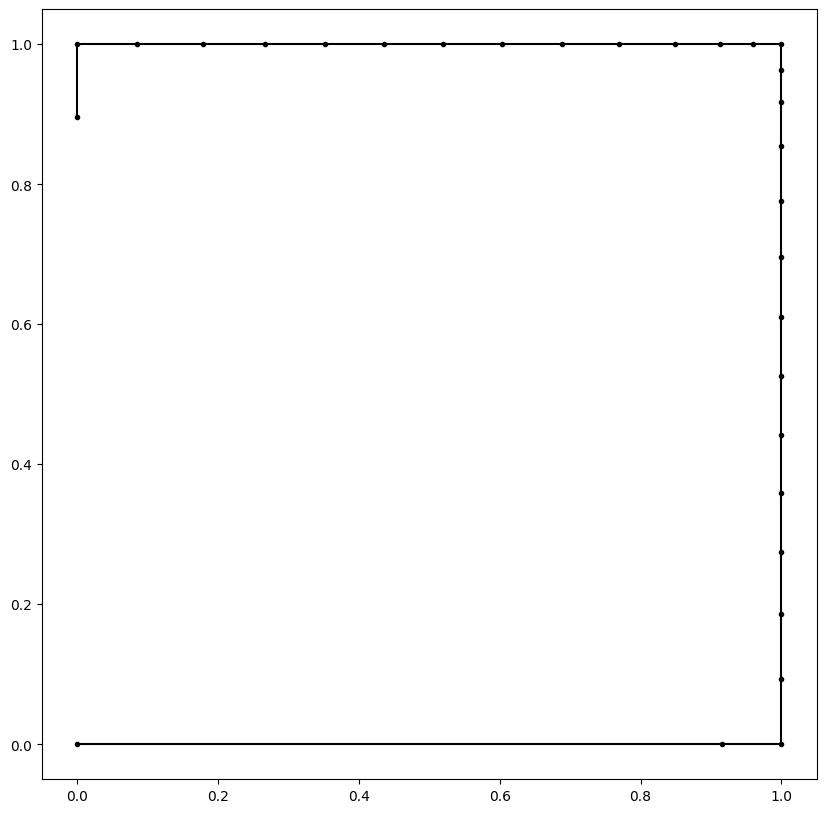

In [18]:
# splitting the edge

v1 = VERTEX(domain_boundary_min[0],domain_boundary_min[1])
v2 = VERTEX(domain_boundary_max[0],domain_boundary_min[1])
v3 = VERTEX(domain_boundary_max[0],domain_boundary_max[1])
v4 = VERTEX(domain_boundary_min[0],domain_boundary_max[1])
findmetric(v1)
findmetric(v2)
findmetric(v3)
findmetric(v4)
split_edge(v1, v2)
print("done1")
split_edge(v2, v3)
print("done2")
split_edge(v3, v4)
print("done3")
split_edge(v4, v1)
print("done4")

boundaryX = []
boundaryY = []
ver = v1
while ver != v2:
    boundaryX.append(ver.x)
    boundaryY.append(ver.y)
    metric = MetricLength(v1, ver)
    # print(MetricLength(v1, ver))
    ver = ver.next
ver = v2
while ver != v3:
    boundaryX.append(ver.x)
    boundaryY.append(ver.y)
    # print(MetricLength(v1, ver))
    ver = ver.next
ver = v3
while ver != v4:
    boundaryX.append(ver.x)
    boundaryY.append(ver.y)
    # print(MetricLength(v1, ver))
    ver = ver.next
ver = v4
while ver != v1:
    boundaryX.append(ver.x)
    boundaryY.append(ver.y)
    # print(MetricLength(v1, ver))
    ver = ver.next
plt.figure(figsize=(10, 10))
plt.plot(boundaryX, boundaryY, '.-k')
New_boundary_coordinates = []
for i in range(len(boundaryX)):
    New_boundary_coordinates.append((boundaryX[i],boundaryY[i]))
 

In [12]:

Metric = []
print(Metric)
for pt in New_boundary_coordinates:
    edge = find_edge(pt, Boundary_edges)
    if edge is not None:
      metric1 = get_metric(edge[0])
      metric2 = get_metric(edge[1])
      required = edge_interpolation(metric1, edge[0], metric2, edge[1], pt) 
      a = required[0]
      b = required[1]
      c = required[2]
      Metric.append((a,b,c))

# Example vertices and their associated metrics
vertices_new = New_boundary_coordinates
metrics_new = Metric

# Create a dictionary to store the vertices and their associated metrics
vert_to_metr = {v: m for v, m in zip(vertices_new, metrics_new)}

# Function to retrieve the metric for a given vertex - returns the metric in the form of a tuple (x,y,z)
def get_metric_new(vertex):
    term = vert_to_metr.get(vertex, None)  # Returns None if the vertex is not found
    return term


[(0, 0), (0.8103067874908447, 0.0), (0.8898443524723234, 0.0), (0.937498318261646, 0.0), (0.9774176958656031, 0.0), (1, 0), (1.0, 0.036941349506378174), (1.0, 0.07403869245663941), (1.0, 0.11162792155197569), (1.0, 0.14946619669643918), (1.0, 0.18629433812020607), (1.0, 0.22212665718330055), (1.0, 0.2570786246604432), (1.0, 0.2914546247240397), (1.0, 0.32541110956693653), (1.0, 0.35912166407365964), (1.0, 0.3926298832564234), (1.0, 0.4259240674337187), (1.0, 0.45908392526345587), (1.0, 0.4923775790444165), (1.0, 0.5258827085342592), (1.0, 0.5597274141446457), (1.0, 0.5938141558489655), (1.0, 0.6279882854591025), (1.0, 0.6619353531110789), (1.0, 0.695433567745716), (1.0, 0.728213694169477), (1.0, 0.7602570118160799), (1.0, 0.7921444050088868), (1.0, 0.8239239851835024), (1.0, 0.8543069025398635), (1.0, 0.8829409199600851), (1.0, 0.9069163650071703), (1.0, 0.9276349829718891), (1.0, 0.9463725407724543), (1.0, 0.9637412081850286), (1.0, 0.9800735293829805), (1.0, 0.9955799697363341), (1, 

In [13]:
## Implementation
# NOTE: let all the lists defined outside the LBFGS loop start with capital letters

## initialization
interior_vertex_array = np.zeros((len(Interior_vert_list),2))
for i in range(len(Interior_vert_list)):
    interior_vertex_array[i] = ma[Interior_vert_list[i]].point
initial_points = interior_vertex_array.flatten()

# random_points = np.random.rand(36,2)
# initial_points = random_points.flatten()

energy_values = []
gradient_values = []

def energy_gradient_function(initial_points_given): # points input should only be the interior vertices

    # specifying the domains
    Domain_boundary_max = domain_boundary_max
    Domain_boundary_min = domain_boundary_min

    # NOTE: MAKE SURE TO MAINTAIN THE ORDER OF THE VERTICES BEING INPUT INTO THE FUNCTION

    initial_points_given = initial_points_given.reshape(-1,2)

    # convert the numpy array into a list of tuples
    interior_vert_list_f = [] # f - first - intial part of the function
    for i in range(len(initial_points_given)):
        required = tuple(initial_points_given[i])
        interior_vert_list_f.append(required)

    # create a list of the total vertices
    vert_list_f = interior_vert_list_f + New_boundary_coordinates
    ## to write a .vol file from points obtained through delaunay triangulation

    vert_list_f = np.array(vert_list_f)
    tri = Delaunay(vert_list_f)

    # plotting
    plt.figure(figsize=(10, 10))
    plt.triplot(vert_list_f[:,0], vert_list_f[:,1], tri.simplices)
    plt.plot(vert_list_f[:,0], vert_list_f[:,1], '.k')

    # extracting indices information
    indices_list = []
    element_indices = []
    a0 = tri.simplices
    a0 = a0.flatten()
    for i in range(len(a0)):
        indices_list.append(a0[i].item())
        if i%3 == 0:
            element_indices.append((a0[i].item(),a0[i+1].item(),a0[i+2].item()))
    element_indices = list(set(element_indices))

    # extracting coordinates information
    coordinates_list_duplicates = []
    b0 = vert_list_f[tri.simplices]
    b0 = b0.flatten()  
    for i in range(len(b0)):
        if i%2 == 0:
            coordinates_list_duplicates.append((b0[i].item(),b0[i+1].item()))
    
    # arranging in pairs
    coordinates_indices = []
    for i in range(len(indices_list)):
        coordinates_indices.append((coordinates_list_duplicates[i],indices_list[i]))
    coordinates_indices = list(set(coordinates_indices))

    # # Call the function to write to a file
    write_vol_file(file_name, element_indices, coordinates_indices)

    ## --------------- BEGIN OPERATIONS ON THE FILE ----------------- ##

    # access the file with the updated vertices
    ma = Mesh(file_name)
    n_vert = ma.nv # number of vertices
    n_el = ma.ne # number of elements

    # create a list of interior, boundary and total vertices
    elm_vert_list_f = [] 
    vertices = np.zeros((n_el, 3))
    for el in ma.Elements(VOL):
        v = el.vertices
        # print(ma[v[0]].point,ma[v[1]].point,ma[v[2]].point)
        elm_vert_list_f.append(v)

    # total vertices
    entire_vert_list = []
    for v in ma.vertices:
        entire_vert_list.append(v)

    # total vertices (coordinates)
    vert_list = []
    for i in entire_vert_list:
        vert_list.append(ma[i].point)

    # Example vertices and their associated netgen notation
    vertices = vert_list
    v = entire_vert_list

    # Create a dictionary to store the vertices and their associated metrics
    vertex_to_v = {vertex: v for vertex, v in zip(vertices, v)}

    # Function to retrieve the metric for a given vertex
    def get_v_f(vertex):
        term = vertex_to_v.get(vertex, None)  # Returns None if the vertex is not found
        return term

    # create list of boundary vertices

    boundary_vert_list = []
    for i in vert_list:
        for j in New_boundary_coordinates:
            if (f'{i[0]:.3f}',f'{i[1]:.3f}') == (f'{j[0]:.3f}',f'{j[1]:.3f}'):
                term = get_v_f(i)
                boundary_vert_list.append(term)

    # create a list of vertices with only interior vertices
    interior_vert_list = list(set(entire_vert_list) - set(boundary_vert_list))

    # finding the metric at the newly found interior vertices
    edge_metric_duplicates = []
    inside_metric_duplicates = []
    for i in interior_vert_list:
        n = i.nr
        term = ma[i].point
        for element in Delaunay_coordinates:
            # if new vertex is outside the domain
            if term[0] > Domain_boundary_max[0] or term[0] < Domain_boundary_min[0] or term[1] > Domain_boundary_max[1] or term[1] < Domain_boundary_min[1]:
                required = (1,0,1)
                edge_metric_duplicates.append([required,term,n])
            # if new element positions haven't changed
            if term == element[0]:
                required = get_metric(element[0])
                edge_metric_duplicates.append([required,term,n])
            elif term == element[1]:
                required = get_metric(element[1])
                edge_metric_duplicates.append([required,term,n])
            elif term == element[2]:
                required = get_metric(element[2])
                edge_metric_duplicates.append([required,term,n])
            # point is on one of the edges of the triangle
            elif is_on_edge(term,element) is not None: # checks if point is on the edge
                # checks which edge it belongs to in the element, to obtain the metric at the edge vertices and interpolate it
                for i in range(3):
                    a = i
                    b = (i + 1) % 3
                    x1 = element[a]
                    x2 = element[b]  # Get next point, handling wrap-around
                    if is_on_edge(term,element) == [x1,x2]:
                        mat1 = get_metric(x1)
                        mat2 = get_metric(x2)
                        interpolated_metric = edge_interpolation(mat1,x1,mat2,x2,term)
                        required = interpolated_metric
                        edge_metric_duplicates.append([required,term,n])

                    if is_on_edge(term,element) == [x2,x1]:
                        mat1 = get_metric(x2)
                        mat2 = get_metric(x1)
                        interpolated_metric = edge_interpolation(mat1,x2,mat2,x1,term)
                        required = interpolated_metric
                        edge_metric_duplicates.append([required,term,n])

            # point is inside the triangle
            elif is_point_in_triangle(term,element[0],element[1],element[2]):
                # obtain the barycentric coefficients
                vertices = element[0],element[1],element[2]
                alpha,beta,gamma = barycentric_interpolation(vertices,term)
            
                # refer to alauzet's text - logarithmic interpolation - Mp = M1**alpha * M2**beta * M3**gamma
                # matrix conversion - convert the 1*3 metric array to a 2*2 matrix and raise it to a power
                mat1 = matrix_conversion_coeff(get_metric(element[0]),alpha)
                mat2 = matrix_conversion_coeff(get_metric(element[1]),beta)
                mat3 = matrix_conversion_coeff(get_metric(element[2]),gamma)

                # multiply the matrices, order of multiplication does not matter as it is a symmetric matrix
                result = add_matrices(mat1,mat2,mat3)
                required = result
                inside_metric_duplicates.append([required,term,n])

    # removing edge metric duplicates
    edge_metric = []
    [edge_metric.append(x) for x in edge_metric_duplicates if x not in edge_metric]
  
    # removing inside metric duplicates
    inside_metric = []
    [inside_metric.append(x) for x in inside_metric_duplicates if x not in inside_metric]
  
    implied_metric = np.zeros((n_vert,3))
    vertices_implied_metric = []

    for i in boundary_vert_list:
        term = ma[i].point
        n = i.nr
        for j in New_boundary_coordinates:
            if (f'{term[0]:.3f}',f'{term[1]:.3f}') == (f'{j[0]:.3f}',f'{j[1]:.3f}'):
                m = get_metric_new(j)
                implied_metric[n] = list(m)

    
    # entering metric for the interior vertices
    for i in interior_vert_list:
        n = i.nr
        for j in inside_metric:
            if j[-1] == n:
                required = list(j[0])
                implied_metric[n] = required
        for j in edge_metric:
            if j[-1] == n:
                required = list(j[0])
                implied_metric[n] = required

    i = 0
    for v in implied_metric:
        coordinates = ma[entire_vert_list[i]].point
        vertices_implied_metric.append([v,coordinates])
        i = i + 1
    
    # creating a dictionary of the vertices and their implied metric
    implied_metric_dic = []
    for i in implied_metric:
        implied_metric_dic.append(i)
    
    vertices_f = vert_list
    metrics_f = implied_metric_dic

    # Create a dictionary to store the vertices and their associated metrics
    vert_f_to_metric = {vertex: metric for vertex, metric in zip(vertices_f, metrics_f)}

    # Function to retrieve the metric for a given vertex
    def get_metric_f(vertex):
        return vert_f_to_metric.get(vertex, None)  # Returns None if the vertex is not found
    

    ## --------------- IMPLEMENTING ALL THE STEPS ----------------- ##

    #create a 2D matrix rows being the number of voronoi vertices and columns being the coordinates of each voronoi cell (a list of tuples)

    i = 0
    interior_Voronoi_list = [] # [no of rows will be the number of voronoi cells, no of column will be 5 - ie - the number of voronoi vertices for each cell]
    circumcentre_list = []

    for v in entire_vert_list:

        for el in ma[v].elements:
            v0 = ma[elm_vert_list_f[el.nr][0]].point
            v1 = ma[elm_vert_list_f[el.nr][1]].point
            v2 = ma[elm_vert_list_f[el.nr][2]].point
            circumcentre_list.append(circumcenter(v0[0],v0[1],v1[0],v1[1],v2[0],v2[1]))

    for v in interior_vert_list:

        # stores coordinates of the voronoi cell, first 4 tuples are the vertices, last tuple will be the voronoi cell centre
        voronoi_cell_coordinates = [] 

        for el in ma[v].elements: # el returns all the element indexes # NOTE:LBFGS: Define a class element

            # get the coordinates of element el
            v0 = ma[elm_vert_list_f[el.nr][0]].point 
            v1 = ma[elm_vert_list_f[el.nr][1]].point  # elm_vertex_list[number of element][vertex index within that element]
            v2 = ma[elm_vert_list_f[el.nr][2]].point  # v0,v1,v2 in the form (x,y)

            #finding the circumcentre of the element (vertices of the voronoi cell)
            voronoi_cell_coordinates.append(circumcenter(v0[0],v0[1],v1[0],v1[1],v2[0],v2[1])) #appends the circumcentre of 6 elements surrounding it

        voronoi_cell_coordinates = list(set(voronoi_cell_coordinates)) #removes the duplicate coordinates (2 out of 6)
        voronoi_centre = ma[v].point #return the voronoi centre in the form (x,y)
        voronoi_cell_coordinates = arrange_anticlockwise(voronoi_cell_coordinates, voronoi_centre)
        voronoi_cell_coordinates.append(voronoi_centre)
        interior_Voronoi_list.append(voronoi_cell_coordinates) #Voronoi list - rows:number of voronoi cells, columns:vertices of the voronoi cell


    # a list containing the mesh vertices and their circumucentre which form the vertices of a voronoi cell
    mesh_vertices_and_circumcentre = [] 
    mesh_vertices_and_circumcentre_metric = []
    delaunay_coordinates = []
    for el in ma.Elements(VOL):
        v = el.vertices
        m1 = v[0].nr
        m2 = v[1].nr
        m3 = v[2].nr
        v0 = ma[v[0]].point
        v1 = ma[v[1]].point
        v2 = ma[v[2]].point
        delaunay_coordinates.append([v0,v1,v2])
        mesh_vertices_and_circumcentre.append([v0,v1,v2,circumcenter(v0[0],v0[1],v1[0],v1[1],v2[0],v2[1])]) # in the form (x0,x1,x2,c1), refer to lloyd's energy paper
        mesh_vertices_and_circumcentre_metric.append([implied_metric[m1],implied_metric[m2],implied_metric[m3],circumcenter(v0[0],v0[1],v1[0],v1[1],v2[0],v2[1])]) # the metrics here are in order wrt the nodes in Mesh_vertices_and_circumcentre


    ## Reconstructing the Voronoi cells for the boundary vertices

    # NOTE: Data sets local to this section are defined with captial and small starting letters
    # NOTE! =  Centroid everywhere here refers to the circumcentre of the deluanay mesh vertices
    # referring to the .vol file - the corner vertics are the first 4 vertices (refer to point list)
    #Creating a list of the corner vertices
    
    a = Domain_boundary_min
    b = (Domain_boundary_max[0],Domain_boundary_min[1])
    c = Domain_boundary_max
    d = (Domain_boundary_min[0],Domain_boundary_max[1])
    corner_Vertices = [a,b,c,d]
    corner_Vertices = arrange_anticlockwise(corner_Vertices,(0.01,0.01))

    # Sort the list by the angle
    Corner_Vertices = [get_v_f(corner_Vertices[0]),get_v_f(corner_Vertices[1]),get_v_f(corner_Vertices[2]),get_v_f(corner_Vertices[3])]
    # NOTE: Corner vertices in the file are always arranged in an anticlockwise direction in the column

    Corner_boundary_elements = [] # stores [[v0,v1,v2,circumcentre,metric associated with that element,"here-(v0,v1 - ie the edge of the element associated with that boundary)""...]
    three_boundary_corner_elements = [] # stores [[v0,v1,v2,circumcentre,metric associated with that element,"here v0 is the mesh vertex, and all three vertices of this element is on the boundary)""...]
    for vertex in Corner_Vertices:
        vert = ma[vertex].point
        for el in ma[vertex].elements:
            vt0 = elm_vert_list_f[el.nr][0] # in the form V1,V2..etc
            vt1 = elm_vert_list_f[el.nr][1]
            vt2 = elm_vert_list_f[el.nr][2]
            n = el.nr
            v0 = ma[vt0].point
            v1 = ma[vt1].point
            v2 = ma[vt2].point
            vtr0,vtr1,vtr2 = vt0.nr, vt1.nr, vt2.nr

            # for the case of a target metric
            a = (implied_metric[vtr0][0] + implied_metric[vtr1][0] + implied_metric[vtr2][0])/3
            b = (implied_metric[vtr0][1] + implied_metric[vtr1][1] + implied_metric[vtr2][1])/3
            c = (implied_metric[vtr0][2] + implied_metric[vtr1][2] + implied_metric[vtr2][2])/3
            Metric = (a,b,c)

            # element not sharing corner vertex with any other element
            if vt0 in boundary_vert_list and vt1 in boundary_vert_list and vt2 in boundary_vert_list:
                element_list = [v0,v1,v2]
                for i in element_list:
                    if i == vert:
                        element_list.remove(i)
                element_list.insert(0,vert)  # to make sure the first element of the list is the corner vertex
                three_boundary_corner_elements.append([element_list[0],element_list[1],element_list[2],circumcenter(v0[0],v0[1],v1[0],v1[1],v2[0],v2[1]),Metric,vertex])
            # elements sharing corner vertex with other element
            elif vt0 in boundary_vert_list and vt1 in boundary_vert_list and (v0[0] == v1[0] or v0[1] == v1[1]):
                Corner_boundary_elements.append([v0,v1,v2,circumcenter(v0[0],v0[1],v1[0],v1[1],v2[0],v2[1]),Metric,vertex])
            elif vt1 in boundary_vert_list and vt2 in boundary_vert_list and (v1[0] == v2[0] or v1[1] == v2[1]):
                Corner_boundary_elements.append([v1,v2,v0,circumcenter(v0[0],v0[1],v1[0],v1[1],v2[0],v2[1]),Metric,vertex])
            elif vt0 in boundary_vert_list and vt2 in boundary_vert_list and (v0[0] == v2[0] or v0[1] == v2[1]):
                Corner_boundary_elements.append([v0,v2,v1,circumcenter(v0[0],v0[1],v1[0],v1[1],v2[0],v2[1]),Metric,vertex])

    ## obtaining the extended coordinates from the corner vertices

    # go through corner_boundary_elements and find which corner it's located in - depending on the corner, find the extended coordinates

    Extended_corner_coordinates1 = []
    Extended_corner_coordinates2 = []
    Extended_corner_coordinates3 = []
    Extended_corner_coordinates4 = []

    if len(Corner_boundary_elements) != 0:
        for a1 in Corner_boundary_elements:
            if a1[-1] == Corner_Vertices[0]:
                Extended_corner_coordinates1.append(allotment_corner_non_single(a1)) # allotment corner single returns the extended point along with the edge wrt which the point is extended
        # print("extedned", Extended_corner_coordinates1)
        if len(Extended_corner_coordinates1) != 0:
            result = (find_min_x_min_y(Extended_corner_coordinates1),ma[Corner_Vertices[0]].point)
            Extended_corner_coordinates1.append(result)

        for a1 in Corner_boundary_elements:
            if a1[-1] == Corner_Vertices[1]:
                Extended_corner_coordinates2.append(allotment_corner_non_single(a1))
        if len(Extended_corner_coordinates2) != 0:
            result = (find_max_x_min_y(Extended_corner_coordinates2),ma[Corner_Vertices[1]].point)
            Extended_corner_coordinates2.append(result)

        for a1 in Corner_boundary_elements:
            if a1[-1] == Corner_Vertices[2]:
                Extended_corner_coordinates3.append(allotment_corner_non_single(a1))
        if len(Extended_corner_coordinates3) != 0:
            result = (find_max_x_max_y(Extended_corner_coordinates3),ma[Corner_Vertices[2]].point)
            Extended_corner_coordinates3.append(result)

        for a1 in Corner_boundary_elements:
            if a1[-1] == Corner_Vertices[3]:
                Extended_corner_coordinates4.append(allotment_corner_non_single(a1))
        if len(Extended_corner_coordinates4) != 0:
            result = (find_min_x_max_y(Extended_corner_coordinates4),ma[Corner_Vertices[3]].point)
            Extended_corner_coordinates4.append(result)

    # going through the three_boundary_corner_elements and finding the extended coordinates

    Extended_three_boundary_coordinates1 = []
    Extended_three_boundary_coordinates2 = []
    Extended_three_boundary_coordinates3 = []
    Extended_three_boundary_coordinates4 = []
    
    if len(three_boundary_corner_elements) != 0:
        for a1 in three_boundary_corner_elements:
            if a1[-1] == Corner_Vertices[0]:
                points = allotment_corner_single(a1) # allotment_corner_single returns the extended point as well as the edge vertices wrt which the point is extended
                for i in points:
                    Extended_three_boundary_coordinates1.append(i)
        if len(Extended_three_boundary_coordinates1) != 0:
            result = (find_min_x_min_y(Extended_three_boundary_coordinates1), ma[Corner_Vertices[0]].point)
            Extended_three_boundary_coordinates1.append(result)

        for a1 in three_boundary_corner_elements:
            if a1[-1] == Corner_Vertices[1]:
                points = allotment_corner_single(a1)
                for i in points:
                    Extended_three_boundary_coordinates2.append(i)
        if len(Extended_three_boundary_coordinates2) != 0:
            result = (find_max_x_min_y(Extended_three_boundary_coordinates2), ma[Corner_Vertices[1]].point)
            Extended_three_boundary_coordinates2.append(result)

        for a1 in three_boundary_corner_elements:
            if a1[-1] == Corner_Vertices[2]:
                points = allotment_corner_single(a1)
                for i in points:
                    Extended_three_boundary_coordinates3.append(i)
        if len(Extended_three_boundary_coordinates3) != 0:
            result = (find_max_x_max_y(Extended_three_boundary_coordinates3), ma[Corner_Vertices[2]].point)
            Extended_three_boundary_coordinates3.append(result)

        for a1 in three_boundary_corner_elements:
            if a1[-1] == Corner_Vertices[3]:
                points = allotment_corner_single(a1)
                for i in points:
                    Extended_three_boundary_coordinates4.append(i)
        if len(Extended_three_boundary_coordinates4) != 0:
            result = (find_min_x_max_y(Extended_three_boundary_coordinates4), ma[Corner_Vertices[3]].point)
            Extended_three_boundary_coordinates4.append(result)

    Extended_corner_boundary_coordinates = Extended_corner_coordinates1+Extended_corner_coordinates2+Extended_corner_coordinates3+Extended_corner_coordinates4+Extended_three_boundary_coordinates1+Extended_three_boundary_coordinates2+Extended_three_boundary_coordinates3+Extended_three_boundary_coordinates4

    # create a list of the boundary vertices other than the corner vertices
    Non_corner_boundary_vertices = list(set(boundary_vert_list) - set(Corner_Vertices))

    ## finding the elements which have two of it's vertices on the boundary, other than the corner elements
    Non_corner_boundary_elements = [] # stores [[v0,v1,v2,circumcentre,metric associated with that element,"here-(v0,v1 - ie the edge of the element associated with that boundary)""...]
    for el in ma.Elements(VOL):
        v = el.vertices
        n = el.nr
        vt0,vt1,vt2 = v[0],v[1],v[2] # in the form V1,V2..etc
        vtr0,vtr1,vtr2 = vt0.nr, vt1.nr, vt2.nr

        # for the case of target metric, taking the element vertex metric to interpolate
        a = (implied_metric[vtr0][0] + implied_metric[vtr1][0] + implied_metric[vtr2][0])/3
        b = (implied_metric[vtr0][1] + implied_metric[vtr1][1] + implied_metric[vtr2][1])/3
        c = (implied_metric[vtr0][2] + implied_metric[vtr1][2] + implied_metric[vtr2][2])/3
        Metric = (a,b,c)

        v0 = ma[v[0]].point
        v1 = ma[v[1]].point
        v2 = ma[v[2]].point
        if vt0 in Non_corner_boundary_vertices and vt1 in Non_corner_boundary_vertices and (v0[0] == v1[0] or v0[1] == v1[1]):
            Non_corner_boundary_elements.append([v0,v1,v2,circumcenter(v0[0],v0[1],v1[0],v1[1],v2[0],v2[1]),Metric])
        elif vt1 in Non_corner_boundary_vertices and vt2 in Non_corner_boundary_vertices and (v1[0] == v2[0] or v1[1] == v2[1]):
            Non_corner_boundary_elements.append([v1,v2,v0,circumcenter(v0[0],v0[1],v1[0],v1[1],v2[0],v2[1]),Metric])
        elif vt0 in Non_corner_boundary_vertices and vt2 in Non_corner_boundary_vertices and (v0[0] == v2[0] or v0[1] == v2[1]):
            Non_corner_boundary_elements.append([v0,v2,v1,circumcenter(v0[0],v0[1],v1[0],v1[1],v2[0],v2[1]),Metric])

    # finding the list of extended vertices for the non corner boundary coordinates
    Extended_non_corner_coordinates = []
    for term in Non_corner_boundary_elements:
        Extended_non_corner_coordinates.append(allotment_corner_non_single(term)) # allotment_corner_non_single works for the non corner boundary elements as well

    Total_extended_coordinates = Extended_corner_boundary_coordinates + Extended_non_corner_coordinates


    ## reconstructing the voronoi cells from the newly extended vertices

    # voronoi list will store all the voronoi vertices in the anticlockwise direction, with the last element in each element of the list being the mesh vertex, ie, centre of the voronoi cell
    boundary_Voronoi_list = []
    for v in boundary_vert_list:
        n = v.nr
        vertex = ma[v].point # (x,y) coordinates of the vertex
        Reconstructed_Voronoi_cell_coordinates = []
        
        # go through each element associated with vertex and find it's circumcentre (these circumcentres have metrics assigned to them in the next section)
        for el in ma[v].elements:
            v0 = ma[elm_vert_list_f[el.nr][0]].point 
            v1 = ma[elm_vert_list_f[el.nr][1]].point 
            v2 = ma[elm_vert_list_f[el.nr][2]].point
            Reconstructed_Voronoi_cell_coordinates.append(circumcenter(v0[0],v0[1],v1[0],v1[1],v2[0],v2[1])) #appends the circumcentre of 6 elements surrounding it
        Reconstructed_Voronoi_cell_coordinates = list(set(Reconstructed_Voronoi_cell_coordinates)) #removes the duplicate coordinates (2 out of 6)
        k = 0
        # find the extended coordinates wrt that particular boundary vertex (metric of the extended coordinates need to be assigned)
        for i in Total_extended_coordinates:
            if vertex in i: # if the edge through which the extended coordinates is formed, has one of it's edge vertices as the centre of the voronoi cell, append that extended coordinate to the voronoi cell
                Reconstructed_Voronoi_cell_coordinates.append(i[0]) # i[0] will be the extended coordinate
        Reconstructed_Voronoi_cell_coordinates = arrange_anticlockwise(Reconstructed_Voronoi_cell_coordinates,vertex)
        Reconstructed_Voronoi_cell_coordinates.append(vertex)
        boundary_Voronoi_list.append(Reconstructed_Voronoi_cell_coordinates)

    # assigning the metric of the closest boundary vertex to the extended vertices
    extended_vertex_metric = []
    for element in Total_extended_coordinates:
        distance_list = []
        for i in boundary_vert_list:
            n = i.nr
            metric = implied_metric[n]
            point = ma[i].point
            distance_list.append((distance(point,element[0]),metric))
        distance_list.sort(key = lambda x: x[0])
        extended_vertex_metric.append((distance_list[0][1], element[0]))



    ## Calculate the metric at the circumcentre of each delaunay triangle

    # circumcentre metric lists contain ([[a,b,c],circumcentre].. for all the delaunay triangles), where a,b,c is the metric
    outside_circumcentre = []
    inside_circumcenter_metric = [] # contains ([[a,b,c],circumcentre].. for all the delaunay triangles), where a,b,c is the metric
    outside_circumcentre_metric = []
    edge_metric_duplicates = []
    circumcentre_list = list(set(circumcentre_list))
    for term in circumcentre_list:

        # point is outside the domain
        distance_at_boundary = []
        if term[0] > Domain_boundary_max[0] or term[0] < Domain_boundary_min[0] or term[1] > Domain_boundary_max[1] or term[1] < Domain_boundary_min[1]:
            outside_circumcentre.append(term) # list contains all the circumcentres outside the domain

            for i in vertices_implied_metric: # NOTE: try to use a much more efficient search algorithm
                distance_at_boundary.append([i[0],distance(term,i[1])]) # stores the metric of the boundary vertices and the distance of the circumcentre from the boundary vertices
                
                # sort distance_at_boundary based on the distance of the the circumcentre from the boundary vertices
                distance_at_boundary.sort(key = lambda x: x[1])
                # assign the metric of the closest boundary mesh vertex to this circumcentre
                outside_circumcentre_metric.append([(distance_at_boundary[0][0]),term])

        # point is inside the domain
        else:
    
            for element in delaunay_coordinates:

            # NOTE: the elements in delaunay coordinates and Mesh_vertices_and_circumcentre are in the same order as they run under the same loop
            # point is on one of the vertices of the triangle
                if term == element[0]:
                    required = get_metric_f(term)
                    edge_metric_duplicates.append([required,term])
                if term == element[1]:
                    required = get_metric_f(term)
                    edge_metric_duplicates.append([required,term])
                if term == element[2]:
                    required = get_metric_f(term)
                    edge_metric_duplicates.append([required,term])
            # point is on one of the edges of the triangle
                if is_on_edge(term,element) is not None: # checks if point is on the edge
                    # checks which edge it belongs to in the element, to obtain the metric at the edge vertices and interpolate it
                    for i in range(3):
                        a = i
                        b = (i + 1) % 3
                        x1 = element[a]
                        x2 = element[b]  # Get next point, handling wrap-around
                        if is_on_edge(term,element) == [x1,x2]:
                            mat1 = get_metric_f(x1)
                            mat2 = get_metric_f(x2)
                            interpolated_metric = edge_interpolation(mat1,x1,mat2,x2,term)
                            required = np.array([interpolated_metric[0],interpolated_metric[1],interpolated_metric[2]])
                            edge_metric_duplicates.append([required,term])

                        if is_on_edge(term,element) == [x2,x1]:
                            mat1 = get_metric_f(x2)
                            mat2 = get_metric_f(x1)
                            interpolated_metric = edge_interpolation(mat1,x2,mat2,x1,term)
                            required = np.array([interpolated_metric[0],interpolated_metric[1],interpolated_metric[2]])
                            edge_metric_duplicates.append([required,term])

                # point is inside the triangle
                elif is_point_in_triangle(term,element[0],element[1],element[2]):
                    
                    # obtain the barycentric coefficients
                    vertices = element[0],element[1],element[2]
                    alpha,beta,gamma = barycentric_interpolation(vertices,term)
                
                    # refer to alauzet's text - logarithmic interpolation - Mp = M1**alpha * M2**beta * M3**gamma
                    # matrix conversion - convert the 1*3 metric array to a 2*2 matrix and raise it to a power
                    mat1 = matrix_conversion_coeff(get_metric_f(element[0]),alpha)
                    mat2 = matrix_conversion_coeff(get_metric_f(element[1]),beta)
                    mat3 = matrix_conversion_coeff(get_metric_f(element[2]),gamma)

                    # multiply the matrices, order of multiplication does not matter as it is a symmetric matrix
                    result = add_matrices(mat1,mat2,mat3)
                    required = np.array([result[0],result[1],result[2]])
                    inside_circumcenter_metric.append([required,term])

    # removing edge metric duplicates
    edge_metric= []
    for i in range(len(edge_metric_duplicates) - 1):
        if edge_metric_duplicates[i+1][1] == edge_metric_duplicates[i][1]:
            edge_metric.append(edge_metric_duplicates[i])
    
    interior_circumcenter_metric = inside_circumcenter_metric + edge_metric + outside_circumcentre_metric # from the contribution of the domain cells
    circumcenter_metric = interior_circumcenter_metric + extended_vertex_metric # including the contribution of the extended vertices



    ## create a list of all the simplexes with the metric associated with each simplex : create a list of voronoi cells with it's simplexes and the metric associated with each simplex vertex

    # find the continuous metric field within each simplex
    interior_simplex_list = [] # [[(c1,metric at c1),(c2,metric at c2),(x0,metric at x0)].....] - for all the simplices
    interior_voronoi_list_simplex_and_metric = [] # [[[[(c1,metric at c1),(c2,metric at c2),(x0,metric at x0)].....]- for each simplex in a voronoi cell].....] - for all the voronoi cells
    for i in range(len(interior_Voronoi_list)):
        simplex_list_0 = []
        v2 = interior_Voronoi_list[i][-1] # represents the mesh vertex
        # assigning metric to the mesh vertex
        for term in vertices_implied_metric:
            if term[1] == v2:
                metric2 = term[0]

        for k in range(len(interior_Voronoi_list[i])-2): # except the last simplex
                # assigning metric to the circumcentres(Voronoi vertices)
                v0 = interior_Voronoi_list[i][k]
                for term in interior_circumcenter_metric:
                    if term[1] == v0:
                        metric0 = term[0]
                v1 = interior_Voronoi_list[i][k+1]
                for term in interior_circumcenter_metric:
                    if term[1] == v1:
                        metric1 = term[0]
                interior_simplex_list.append([(v0,metric0),(v1,metric1),(v2,metric2)])
                simplex_list_0.append([(v0,metric0),(v1,metric1),(v2,metric2)])

        v0 = interior_Voronoi_list[i][len(interior_Voronoi_list[i])-2]
        for term in interior_circumcenter_metric:
            if term[1] == v0:
                metric0 = term[0]
        v1 = interior_Voronoi_list[i][0]
        for term in interior_circumcenter_metric:
            if term[1] == v1:
                metric1 = term[0]
        interior_simplex_list.append([(v0,metric0),(v1,metric1),(v2,metric2)])
        simplex_list_0.append([(v0,metric0),(v1,metric1),(v2,metric2)])
        interior_voronoi_list_simplex_and_metric.append(simplex_list_0)

    boundary_simplex_list = []
    boundary_voronoi_list_simplex_and_metric = []
    for i in range(len(boundary_Voronoi_list)):
        simplex_list_0 = []
        v2 = boundary_Voronoi_list[i][-1] # represents the mesh vertex
        # assigning metric to the mesh vertex
        for term in vertices_implied_metric:
            if term[1] == v2:
                metric2 = term[0]

        for k in range(len(boundary_Voronoi_list[i])-2): # except the last simplex
                # assigning metric to the circumcentres(Voronoi vertices)                             
                v0 = boundary_Voronoi_list[i][k]                                                       
                for term in circumcenter_metric:                                              
                    if term[1] == v0:
                        metric0 = term[0]
                v1 = boundary_Voronoi_list[i][k+1]
                for term in circumcenter_metric:
                    if term[1] == v1:
                        metric1 = term[0]
                boundary_simplex_list.append([(v0,metric0),(v1,metric1),(v2,metric2)])
                simplex_list_0.append([(v0,metric0),(v1,metric1),(v2,metric2)])

        v0 = boundary_Voronoi_list[i][len(boundary_Voronoi_list[i])-2]
        for term in circumcenter_metric:
            if term[1] == v0:
                metric0 = term[0]
        v1 = boundary_Voronoi_list[i][0]
        for term in circumcenter_metric:
            if term[1] == v1:
                metric1 = term[0]
        boundary_simplex_list.append([(v0,metric0),(v1,metric1),(v2,metric2)])
        simplex_list_0.append([(v0,metric0),(v1,metric1),(v2,metric2)])
        boundary_voronoi_list_simplex_and_metric.append(simplex_list_0)

    voronoi_list_simplex_and_metric = interior_voronoi_list_simplex_and_metric + boundary_voronoi_list_simplex_and_metric
    simplex_list = interior_simplex_list + boundary_simplex_list


    ## finding the energy of each voonoi cell - integrating using gaussian quadrature

    energy_list = [] # stores the energy of each voronoi cell along with the it's voronoi centre(mesh vertex around which the voronoi cell is constructed) [((x,y),energy),...]
    for term in voronoi_list_simplex_and_metric:
        energy = 0
        for simplex in term:
            v0,v1,vi = simplex[0][0], simplex[1][0], simplex[2][0]
            G0,G1,Gi = simplex[0][1],simplex[1][1],simplex[2][1]

            a = (G0[0] + G1[0] + Gi[0])/3
            b = (G0[1] + G1[1] + Gi[1])/3
            c = (G0[2] + G1[2] + Gi[2])/3
            G = (a,b,c)

            energy = energy + simplex_energy(v0,v1,vi,G)
        energy_list.append((term[0][-1][0],energy))

    # obtaining the energy of only the interior voronoi cells
    interior_vert_coordinates = []
    for i in interior_vert_list:
        interior_vert_coordinates.append(ma[i].point)
    
    interior_energy_list = []
    for i in energy_list:
        if i[0] in interior_vert_coordinates:
            interior_energy_list.append(i[1])

    interior_energy = 0

    # check if any of the points lie outside the domain - if they do, increase energy value, to prevent selecting this point
    for term in vert_list_f:
        if term[0] > Domain_boundary_max[0] or term[0] < Domain_boundary_min[0] or term[1] > Domain_boundary_max[1] or term[1] < Domain_boundary_min[1]:
            interior_energy = initialisation
    
    for i in interior_energy_list:
        interior_energy = interior_energy + i

    total_energy = 0
    for i in energy_list:
        total_energy = total_energy + i[1]


    ## finding the gradient of each voonoi cell - integrating using gaussian quadrature

    # create a list to store all the mesh vertices and the energy gradient vector beside it
    gradient_list = []
    for v in entire_vert_list:
        gradient_list.append([ma[v].point])
    for i in range(len(gradient_list)):
        gradient_list[i].append([0.0,0.0]) # [x,y] gradient vectors can be added to [0,0]

    for i in range(len(simplex_list)):
        c1_dependants = [] # to store list of delaunay edges c1 is found from
        c2_dependants = [] # 
        #simplex coordinates
        c1 = simplex_list[i][0][0] # circumcentre 1 = part of the voronoi cell vertex
        c2 = simplex_list[i][1][0] # circumcentre 2 = part of the voronoi cell vertex
        x0 = simplex_list[i][2][0] # voronoi cell centre (Mesh vertex, ie, part of the delaunay triangle)

        # obtaining the constant metric of the simplex, by averaging the metrics of the vertices
        G0,G1,Gi = simplex_list[i][0][1],simplex_list[i][1][1],simplex_list[i][2][1] # metrics of the simplex vertices
        a = (G0[0] + G1[0] + Gi[0])/3
        b = (G0[1] + G1[1] + Gi[1])/3
        c = (G0[2] + G1[2] + Gi[2])/3
        G = (a,b,c)
        
        # Mesh_vertex_and_circumcentre = [[x0,x1,x2,C1],...]

        # find the delaunay edges (mesh vertices) that C1 depends on
        i = 0
        Triangle1_c1 = []
        Triangle2_c1 = []

        for v in mesh_vertices_and_circumcentre:

            if v[-1] == c1:
                i = i+1
                ind = mesh_vertices_and_circumcentre.index(v)
                a = mesh_vertices_and_circumcentre[ind][0:3]

                if i == 1:
                    # NOTE: if the circumcentre is unique to one delaunay triangle, then length of triangle2_c1 will be 0
                    Triangle1_c1.append(a) # first triangle dependant on c1
                    Triangle1_c1 = Triangle1_c1[0] # as it is a list within a list [[]]

                if i>1: # this case satisfied only when the circumcentre is not unique to one delaunay triangle
                    Triangle2_c1.append(a) # second triangle dependant on c1
                    Triangle2_c1 = Triangle2_c1[0]

                c1_dependants.append(a) # returns a list of list of delaunay vertices on which c1 depends on

        c1_dependants = list(set(flatten(c1_dependants))) # returns list of vertices c1 depends on [x0,x1,x2,x3]

        # find the delaunay edges (mesh vertices) that C2 depends on
        i = 0 # i only required when eac simplex vertex, ie, triangle circumcentre is not unique to one delaunay triangle
        Triangle1_c2 = []
        Triangle2_c2 = []

        for v in mesh_vertices_and_circumcentre:

            if v[-1] == c2:
                i = i + 1
                ind = mesh_vertices_and_circumcentre.index(v)
                b = mesh_vertices_and_circumcentre[ind][0:3] # takes first three items, ie, x0,x1,x2, ie, the delaunay edges

                if i == 1:
                    # NOTE: if the circumcentre is unique to one delaunay triangle, then length of triangle2_c2 will be 0
                    Triangle1_c2.append(b) # first triangle dependant on c2
                    Triangle1_c2 = Triangle1_c2[0]

                if i>1:
                    Triangle2_c2.append(b) # second triangle dependant on c2
                    Triangle2_c2 = Triangle2_c2[0]

                c2_dependants.append(b) # returns a list of list of delaunay vertices on which c2 depends on

        c2_dependants = list(set(flatten(c2_dependants))) # returns list of vertices c2 depends on [x0,x1,x2,x3]      

        ### ------------------------------------------Energy gradient calculations--------------------------------------------- ###

        ## calculation of dc/dxi

        # writing function for dc/dxi, where x's wrt c, to which the respective delaunay triangle and simplex belongs to.
        # if the main loop is running through the simplex with the voronoi centre x0, and vertices c1 and c2, looping through the surrounding voronoi cells with centre xi
        # for dc1/dxi, c1 will be the circumcentre of 2 delaunay triangles. The delaunay triangle used to find dc1/dxi should be chosen in such a way that it contains x0(simplex voronoi centre), and the original simplex. 
        # If it cannot contain xi, choose the delaunay triangle which contains xi.        
    
        # find delaunay triangle containing x0 and the simplex (c1,c2,x0), this can be used for dc1/dx0 and dc2/dx0
        if len(c1_dependants) != 0:

            # if statement to check if the circumcentre is unique or not
            if len(Triangle1_c1) != 0 and len(Triangle2_c1) != 0:

                # for c1, checking which triangle contains x0 and simplex through measuring distances
                Delaunay_triangle_in_C1 = [] # delaunay triangle containing x0 and simplex
                Delaunay_triangle_out_C1 = [] # delaunay triangle may or may not contain x0 but not simplex
                l1,l2,l3 = distance(Triangle1_c1[0],c2),distance(Triangle1_c1[1],c2),distance(Triangle1_c1[2],c2)
                l4,l5,l6 = distance(Triangle2_c1[0],c2),distance(Triangle2_c1[1],c2),distance(Triangle2_c1[2],c2)
                if l1+l2+l3 > l4+l5+l6:
                    Delaunay_triangle_in_C1 = Triangle2_c1
                    Delaunay_triangle_out_C1 = Triangle1_c1
                else:
                    Delaunay_triangle_in_C1 = Triangle1_c1
                    Delaunay_triangle_out_C1 = Triangle2_c1

                # calculate dc1/dxi where xi are the vertices surrounding c1
                dc1_dxi = []
                for i in range(len(c1_dependants)):
                    a1 = c1_dependants[i]
                    #checking if a0 is the inner or outer delaunay triangle vertex
                    if a1 in Delaunay_triangle_in_C1 and Delaunay_triangle_out_C1: # then inner delaunay triangle needs to be taken
                        dc1_dx = gradient_dC_dx(Delaunay_triangle_in_C1[0],Delaunay_triangle_in_C1[1],Delaunay_triangle_in_C1[2],c1,a1)
                    else:
                        dc1_dx = gradient_dC_dx(Delaunay_triangle_out_C1[0],Delaunay_triangle_out_C1[1],Delaunay_triangle_out_C1[2],c1,a1)
                    dc1_dxi.append(dc1_dx)

            # when the circumcentre is unique to one delaunay triangle
            else:
                Delaunay_triangle_C1 = Triangle1_c1
                dc1_dxi = []
                for i in range(len(c1_dependants)):
                    a1 = c1_dependants[i]
                    dc1_dx = gradient_dC_dx(Delaunay_triangle_C1[0],Delaunay_triangle_C1[1],Delaunay_triangle_C1[2],c1,a1)
                    dc1_dxi.append(dc1_dx)

            # iterate through c1_dependants, find gradient energy contribution of element (c1,c2,x0) to the voronoi cell of each mesh vertex in c1_dependants (dF/dx(i))
            k = 0
            for i in c1_dependants:
                for j in gradient_list: #list to store the interior mesh vertices and the energy gradient vector beside it
                    if j[0] == i: # if vertex is equal to the point in c1 dependants
                        index = gradient_list.index(j)
                        gradient_list[index][1][0] += matrix_product(gradient(c1,c2,x0,G,0,1,0),dc1_dxi[k])[0]
                        gradient_list[index][1][1] += matrix_product(gradient(c1,c2,x0,G,0,1,0),dc1_dxi[k])[1]
                k = k+1   


        if len(c2_dependants) != 0:

            # if statement to check if the circumcentre is unique or not
            if len(Triangle1_c2) != 0 and len(Triangle2_c2) != 0:

                # for c2, checking which triangle contains x0 and simplex through measuring distances
                Delaunay_triangle_in_C2 = [] # delaunay triangle containing x0 and simplex
                Delaunay_triangle_out_C2 = [] # delaunay triangle may or may not contain x0 but not simplex
                l1,l2,l3 = distance(Triangle1_c2[0],c1),distance(Triangle1_c2[1],c1),distance(Triangle1_c2[2],c1)
                l4,l5,l6 = distance(Triangle2_c2[0],c1),distance(Triangle2_c2[1],c1),distance(Triangle2_c2[2],c1)
                if l1+l2+l3 > l4+l5+l6:
                    Delaunay_triangle_in_C2 = Triangle2_c2
                    Delaunay_triangle_out_C2 = Triangle1_c2
                else:
                    Delaunay_triangle_in_C2 = Triangle1_c2
                    Delaunay_triangle_out_C2 = Triangle2_c2


                # calculate dc2/dxi where xi are the vertices surrounding c2
                dc2_dxi = []
                for i in range(len(c2_dependants)):
                    a2 = c2_dependants[i]
                    #checking if a0 is the inner or outer delaunay triangle vertex
                    if a2 in Delaunay_triangle_in_C2 and Delaunay_triangle_out_C2: # then inner delaunay triangle needs to be taken
                        dc2_dx = gradient_dC_dx(Delaunay_triangle_in_C2[0],Delaunay_triangle_in_C2[1],Delaunay_triangle_in_C2[2],c2,a2)
                    else:
                        dc2_dx = gradient_dC_dx(Delaunay_triangle_out_C2[0],Delaunay_triangle_out_C2[1],Delaunay_triangle_out_C2[2],c2,a2)
                    dc2_dxi.append(dc2_dx)
            
            # when the circumcentre is unique to one delaunay triangle
            else:
                Delaunay_triangle_C2 = Triangle1_c2
                # Delaunay_triangle_C2 = Delaunay_anticlockwise(Delaunay_triangle_C2,x0)
                dc2_dxi = []
                for i in range(len(c2_dependants)):
                    a2 = c2_dependants[i]
                    dc2_dx = gradient_dC_dx(Delaunay_triangle_C2[0],Delaunay_triangle_C2[1],Delaunay_triangle_C2[2],c2,a2)
                    dc2_dxi.append(dc2_dx)

            # iterate through c2_dependants, find gradient energy contribution of element (c1,c2,x0) to the voronoi cell of each mesh vertex in c2_dependants (dF/dx(i))
            k = 0
            for i in c2_dependants:
                for j in gradient_list:
                    if j[0] == i:
                        index = gradient_list.index(j)
                        gradient_list[index][1][0] += matrix_product(gradient(c1,c2,x0,G,0,0,1),dc2_dxi[k])[0]
                        gradient_list[index][1][1] += matrix_product(gradient(c1,c2,x0,G,0,0,1),dc2_dxi[k])[1]
                k=k+1

        ### --------------------------------------------------------------------------------------------------------------------------------###

        ## energy gradient contribution of simplex i to x0

        for v in gradient_list: # find the voronoi cell it belongs to and append the gradient energy to the same
            if v[0] == x0:
                index = gradient_list.index(v)
                gradient_list[index][1][0] += gradient(c1,c2,x0,G,1,0,0)[0]  
                gradient_list[index][1][1] += gradient(c1,c2,x0,G,1,0,0)[1]

    # list of interior vertex coordinates
    interior_vert_coordinates = []
    for i in interior_vert_list:
        interior_vert_coordinates.append(ma[i].point)

    # list of interior gradient vectors
    interior_gradient_list = []
    for i in gradient_list:
        if i[0] in interior_vert_coordinates:
            interior_gradient_list.append(i[1])

    # converting it into a numpy array
    interior_gradient_list_array = np.zeros((len(interior_gradient_list),2))
    for i in range(len(interior_gradient_list)):
        interior_gradient_list_array[i] = interior_gradient_list[i]

    # flattening it for the LBFGS loop
    required = interior_gradient_list_array.flatten()

    sum_x = 0
    sum_y = 0
    for i in interior_gradient_list:
        sum_x = sum_x + i[0]
        sum_y = sum_y + i[1]

    gradient_sum = [sum_x,sum_y]

    
    energy_values.append(interior_energy)
    gradient_values.append(gradient_sum)

    print(f"Gradient_Sum: {gradient_sum}")
    print("Interior_energy", interior_energy)
    
    return (interior_energy, required)



Gradient_Sum: [np.float64(623.8617980107687), np.float64(20225.76308385995)]
Interior_energy 0.03173526662702961
Gradient_Sum: [np.float64(8257.598039740687), np.float64(-3403.6157010870406)]
Interior_energy 10903.725351956038


KeyboardInterrupt: 

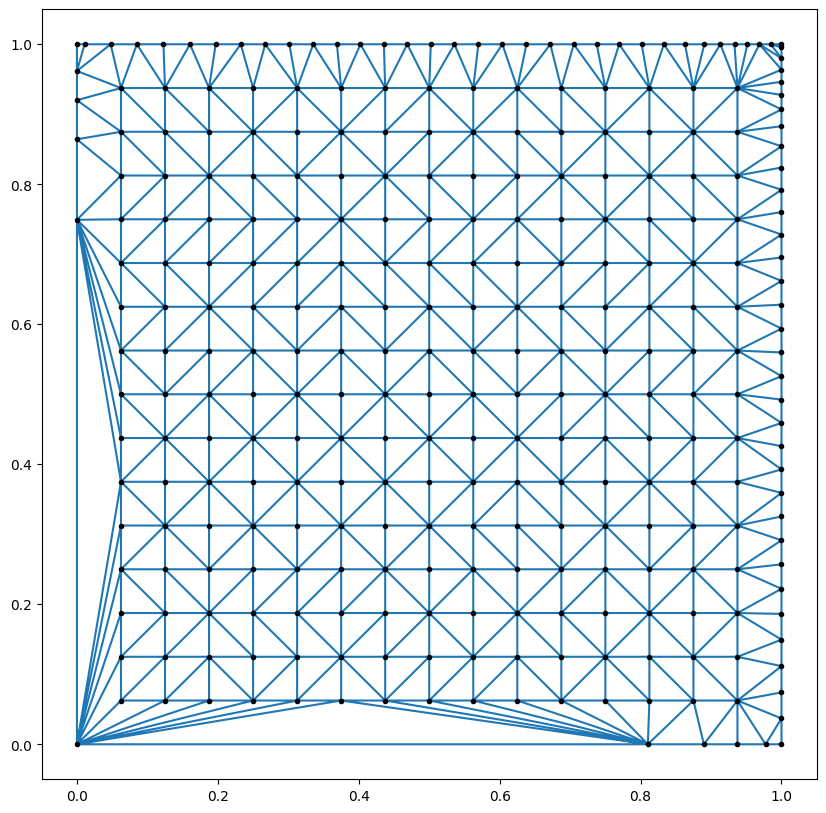

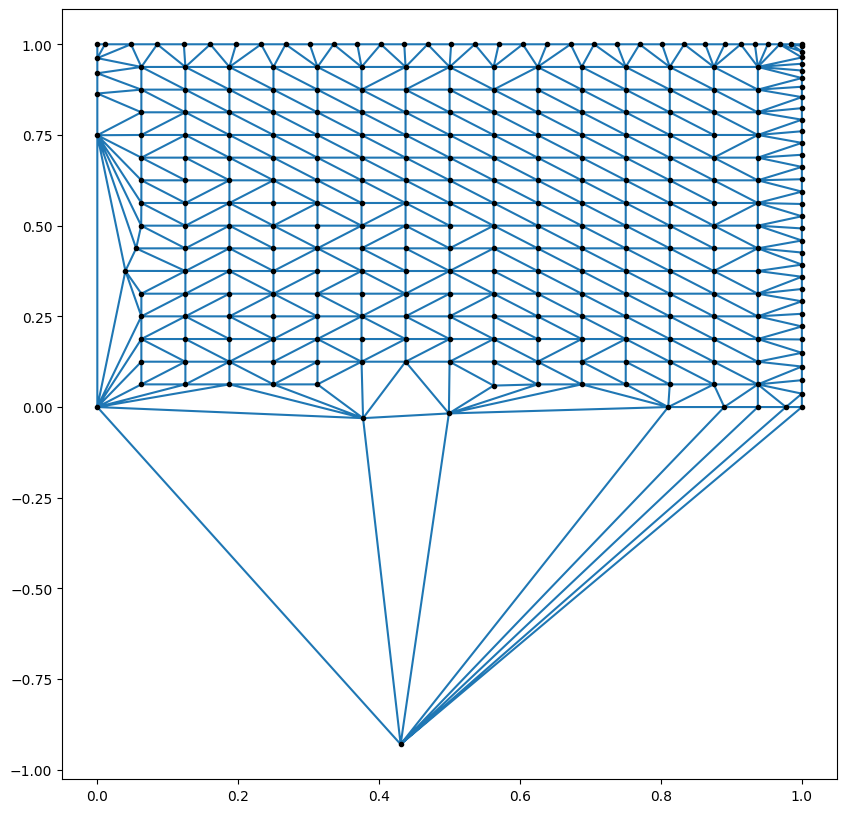

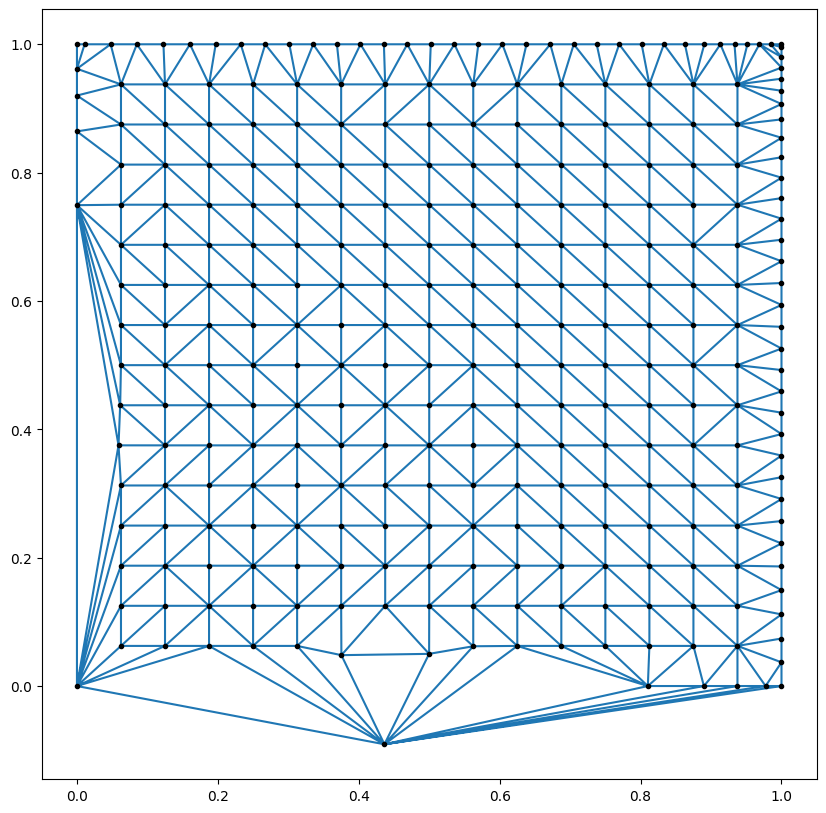

In [14]:
### -----------------IMPLEMENTING LBFGS FOR ENERGY MINIMISAION--------------- ###

# # applying the LBFGS loop
# maxls - maximum number of line search steps in each iteration
# maxcor - M  in lbfgs
# gtol - tolerance in terms of the gradient norm

options = {'maxiter': 1000, 'maxls':2000,'disp': True, 'gtol':10e-16 , 'maxcor': 4}
result = minimize(energy_gradient_function,jac = True, x0 =  initial_points, method = 'L-BFGS-B',options=options) 

required = result.x.reshape(-1,2)
gradient_value = result.jac

print("your result is:")
print(required)
final_energy = result.fun
print(f"Final Energy: {final_energy}")
print(len(initial_points))
print("number",result.nit)